In [ ]:
#Wheat
#Wheat and meslin flour
#Gluten feed and meal
#Glucose and dextrose"

In [ ]:
!pip install statsmodels

In [ ]:
!pip install sktime

In [ ]:
!pip install pmdarima

# Load trade and production data (1993-2023)

In [1]:
import pandas as pd
import os
import numpy as np

trade_directory = "trade_data"

trades = []
for file in os.listdir(trade_directory):
    if file.endswith(".csv"): 
        trades.append(pd.read_csv(os.path.join(trade_directory, file),sep=",",index_col=False,encoding = 'ISO-8859-1'))


trade = pd.concat(trades,ignore_index=True, axis=0)

In [2]:
trade = trade[["refYear","reporterDesc","partnerDesc","flowDesc","qty","isAggregate"]].fillna(0.)

# fill gaps with ARIMA

In [ ]:
def need2be_imputed(tmp,target="qty"):
    if len(tmp) > 0:
        right_empty = 0
        zeros = 0
        flag = True
        for i,row in tmp.reindex().sort_index(ascending=False).iterrows():
            if  math.isnan(row[target]):
                zeros += 1
                if flag:
                    right_empty += 1    
            else:
                flag = False
        if right_empty < 3 and zeros > 0:
            return True, 0
        else:    
            if zeros > 0 and right_empty == zeros:
                return False, right_empty
            else:
                if zeros == 0:
                    return False, 0
                else:    
                    return True, right_empty
    else:    
        return False, 0

In [ ]:
from sktime.transformations.series.impute import Imputer
from sktime.forecasting.arima import AutoARIMA
from sklearn.metrics import mean_squared_error
import warnings
import math
from tqdm import tqdm

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
np.seterr(divide = 'ignore') 

reporters = np.unique(trade['reporterDesc'])

print("Original trade size:", len(trade))

# drop duplicate lines
print("Drop duplicates")
for r in tqdm(reporters):
    for partner in np.unique(trade[trade['reporterDesc'] == r]["partnerDesc"].to_numpy()):
        for flow in ["Import","Export"]:
            years = np.unique(trade["refYear"].to_numpy())
            for year in years:
                year_trade = trade[(trade['reporterDesc']==r)&(trade['flowDesc']==flow)&(trade['refYear']==year)&(trade['partnerDesc']==partner)]
                if len(year_trade) > 1:
                    remain = year_trade['qty'].idxmax()
                    #print(r,partner,len(year_trade))
                    for id_,_ in year_trade.iterrows():
                        if id_ != remain:
                            trade = trade.drop(id_)
                   #print("Control:",r,partner, len(trade[(trade['reporterDesc']==r)&(trade['flowDesc']==flow)&(trade['refYear']==year)&(trade['partnerDesc']==partner)]))        
print("Trade size after de-duplication:",len(trade))
print("Impute nans")
for r in tqdm(reporters):
    for partner in np.unique(trade[trade['reporterDesc'] == r]["partnerDesc"].to_numpy()):
        for flow in ["Import","Export"]:
            years = np.unique(trade["refYear"].to_numpy())
            for year in years:
                if len(trade[(trade['reporterDesc']==r)&(trade['flowDesc']==flow)&(trade['refYear']==year)&(trade['partnerDesc']==partner)]) == 0:
                     row =  pd.DataFrame({"refYear":year,	"reporterDesc":r,	"partnerDesc":partner,	"flowDesc":flow,"qty":math.nan,	"isAggregate":False},index=[0])
                     trade = pd.concat([trade.loc[:],row],axis=0).reset_index(drop=True)

            tmp = trade[(trade['reporterDesc']==r)&(trade['flowDesc']==flow)&(trade['partnerDesc']==partner)]
            flag,zero_len = need2be_imputed(tmp)
            if flag:
                X = tmp
                #nulls = np.isnan(X['qty'].to_numpy())
                transformer = Imputer(method="forecaster", forecaster=AutoARIMA(d=0, suppress_warnings=True))
                X_ = transformer.fit_transform(X['qty'].to_numpy().flatten()[:len(X) - zero_len])
    
                #print(X['qty'].to_numpy().flatten(), "-->", X_.flatten())
                for i,v in enumerate(X.iterrows()):
                    idx, row = v
                    if i < len(X_):
                        if X_[i] > 0.:
                            trade.loc[idx,"qty"] = X_[i]
                        

trade = trade.fillna(0.)

print("Final trade size:",len(trade))

In [ ]:
trade.to_csv("trade.csv",sep=";")

In [17]:
reporters = np.unique(trade['reporterDesc'])

In [18]:
len(reporters)

211

In [3]:
import pandas as pd
import numpy as np

trade = pd.read_csv("trade.csv",sep=";",index_col=0)

In [19]:
trade


,Unnamed: 0,refYear,reporterDesc,partnerDesc,flowDesc,qty,isAggregate
0,0,2015,Albania,World,Import,235833190.0,False
1,1,2015,Albania,Hungary,Import,6647930.0,False
2,2,2015,Albania,Italy,Import,1304800.0,False
3,3,2015,Albania,Russian Federation,Import,173209449.0,False
4,4,2015,Albania,Serbia,Import,48333715.0,False
...,...,...,...,...,...,...,...
581679,581679,2014,Zimbabwe,Zambia,Export,0.0,False
581680,581680,2016,Zimbabwe,Zambia,Export,0.0,False
581681,581681,2017,Zimbabwe,Zambia,Export,0.0,False
581682,581682,2018,Zimbabwe,Zambia,Export,0.0,False


In [25]:
trade_aggregate = trade[trade["flowDesc"] == "Import"][["refYear","qty"]].groupby(["refYear"])["qty"].sum()

In [27]:
pd.DataFrame(trade_aggregate).to_csv("World_Import_by_year.csv")

In [28]:
trade_aggregate = trade[trade["flowDesc"] == "Export"][["refYear","qty"]].groupby(["refYear"])["qty"].sum()

In [29]:
pd.DataFrame(trade_aggregate).to_csv("World_Export_by_year.csv")

In [ ]:
area_map = {"Belgium-Luxembourg":"Belgium-Luxembourg (...1998)",
"Bosnia and Herzegovina":"Bosnia Herzegovina",
"China, Taiwan Province of":"Taiwan",
"China, mainland":"China",
"Democratic People's Republic of Korea":"Democratic People's Republic of Korea",
"Democratic Republic of the Congo":"Dem. Rep. of the Congo",
"Iran (Islamic Republic of)":"Iran",
"Netherlands (Kingdom of the)":"Netherlands",
"Palestine":"State of Palestine",
"Republic of Korea":"Rep. of Korea",
"Republic of Moldova":"Rep. of Moldova",
"Serbia and Montenegro":"Serbia and Montenegro (...2005)",
"Somalia":"Somalia",
"South Sudan":"Sudan",
"Sudan (former)":"Sudan (...2011)",
"Syrian Arab Republic":"Syria",
"United Kingdom of Great Britain and Northern Ireland":"United Kingdom",
"United Republic of Tanzania":"United Rep. of Tanzania",
"United States of America":"USA",
"Venezuela (Bolivarian Republic of)":"Venezuela"}

area_map_inv = {v:k for k,v in area_map.items()}

In [ ]:
area_map_inv

# Prepare FAO

In [ ]:
from sktime.transformations.series.impute import Imputer
from sktime.forecasting.arima import AutoARIMA
from sklearn.metrics import mean_squared_error
import warnings

fao = pd.read_csv("prod_data/FAOSTAT_data_en_1-28-2025.csv")[["Area", "Year", "Value"]]

years = np.unique(trade["refYear"].to_numpy())
areas = np.unique(trade['reporterDesc'].to_numpy())


for r in areas:
    if r in area_map_inv:
        print(area_map_inv[r],"-->",r)
        for idx,row in fao[fao["Area"] == area_map_inv[r]].iterrows():
            row["Area"] = r
            fao.loc[idx] = row
    

    for year in years:
        if len(fao[(fao['Area']==r)&(fao['Year']==year)]) == 0:
             row =  pd.DataFrame({"Area":r,	"Year":year,"Value":math.nan},index=[0])
             fao = pd.concat([fao.loc[:],row],axis=0).reset_index(drop=True)
            

    #if empty:        
    #    print("Zeros: ", r)
    tmp = fao[(fao['Area']==r)]
    flag,zero_len = need2be_imputed(tmp,"Value")
    if flag:
        X = tmp
        transformer = Imputer(method="forecaster", forecaster=AutoARIMA(d=0, suppress_warnings=True))
        X_ = transformer.fit_transform(X['Value'].to_numpy().flatten()[:len(X) - zero_len])

        print(X['Value'].to_numpy().flatten(), "-->", X_.flatten())
        for i,v in enumerate(X.iterrows()):
            idx, row = v
            if i < len(X_):
                if X_[i] > 0.:
                    fao.loc[idx,"Value"] = X_[i]  

print("Drop duplicates")
for r in tqdm(areas):
    for year in years:
        year_trade = fao[(fao['Area']==r)&(fao['Year']==year)]
        if len(year_trade) > 1:
            remain = year_trade['Value'].idxmax()
            print(r,len(year_trade))
            for id_,_ in year_trade.iterrows():
                if id_ != remain:
                    fao = fao.drop(id_)
                    
fao.to_csv("fao.csv",sep=";")

In [ ]:
pd.read_csv("prod_data/FAOSTAT_data_en_1-28-2025.csv").columns

In [ ]:
fao = pd.read_csv("fao.csv",sep=";",index_col=0)

In [ ]:
fao = fao.fillna(0.)

In [ ]:
fao

# Build baseline dataset

In [ ]:
import pandas as pd
import os
import numpy as np
from tqdm import tqdm

trade = pd.read_csv("trade.csv",sep=";")
reporters = np.unique(trade['reporterDesc'])
#export per country. 5 year window.

datas = []
for r in tqdm(reporters):
    for partner in np.unique(trade[trade['reporterDesc'] == r]["partnerDesc"].to_numpy()):
        if r.find(", nes")==-1 and r.find("North America")==-1 and r.find("World") == -1 and  r.find("Union") == -1 and r.find("19") == -1 and r.find("20") == -1:
            if partner.find(", nes")==-1 and partner.find("North America")==-1 and partner.find("World") == -1 and  partner.find("Union") == -1 and partner.find("19") == -1 and partner.find("20") == -1:             
                #print(r,partner)
                data = np.nan_to_num(trade[(trade['reporterDesc'] == r)&(trade['partnerDesc'] == partner)&(trade['flowDesc'] == "Export")]['qty'].to_numpy().reshape(1,-1,1))
                data2 = np.nan_to_num(trade[(trade['reporterDesc'] == r)&(trade['partnerDesc'] == partner)&(trade['flowDesc'] == "Import")]['qty'].to_numpy().reshape(1,-1,1))
                data3 = np.nan_to_num(fao[fao["Area"] == r][["Value"]].to_numpy().reshape(1,-1,1))
                data4 = np.nan_to_num(fao[fao["Area"] == partner][["Value"]].to_numpy().reshape(1,-1,1))
                if data4.shape[1] > 0 and data3.shape[1] > 0:
                    #print(data.shape,data2.shape,data3.shape,data4.shape)
                    data = np.concatenate([data,data2,data3,data4],axis=2)
                    datas.append(data)

base_dataset = np.vstack(datas)

In [ ]:
base_dataset.shape

In [ ]:
np.save("base_dataset.npy",base_dataset)

In [ ]:
!pip install tkan

# Baselines

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
base_dataset = np.load("base_dataset.npy")
base_datasetX = base_dataset[:,:30,:]
base_datasety = base_dataset[:,1:31,0]

base_datasetX = base_datasetX.reshape(-1,5,4)
base_datasety = base_datasety.reshape(-1,5,1)

X_train, X_test, y_train, y_test = train_test_split(base_datasetX,base_datasety,test_size = 0.33)


In [ ]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn


def printf(*args, fname="log.txt"):
    with open(join("test_outputs",fname),"a+") as f:
        for a in args:
            f.write(str(a) + " ")
        f.write("\n") 
    print(args) 

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
import optuna
from tkan import TKAN
from tensorflow.keras import regularizers
from tkan import TKAN

#np.bool = np.bool_

from sklearn.model_selection import KFold
#xgb.set_config(verbosity=2)

def make_modelLSTM(input_shape, hidden_size, dropout):
    input_layer = tf.keras.layers.Input(input_shape)
    #dim = tf.zeros([batch_size,hidden_size])  
    output_layer = tf.keras.layers.LSTM(hidden_size, return_sequences=True,dropout=dropout)(input_layer)#, initial_state=[dim, dim])
    output_layer2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation='linear'))(output_layer)    
    return tf.keras.models.Model(inputs=input_layer, outputs=output_layer2)
 
def make_GRU(input_shape, hidden_size, dropout):
    input_layer = tf.keras.layers.Input(input_shape)
    output_layer = tf.keras.layers.GRU(hidden_size, return_sequences=True,dropout=dropout)(input_layer)#, initial_state=[dim, dim])
    output_layer2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation='linear'))(output_layer)    
    return tf.keras.models.Model(inputs=input_layer, outputs=output_layer2)

def make_modelTKAN(input_shape, hidden_size, dropout):
    model = tf.keras.Sequential([
          tf.keras.layers.InputLayer(input_shape=input_shape),
          TKAN(hidden_size, sub_kan_configs=[{'spline_order':3}], return_sequences=True, use_bias=True, kernel_regularizer=regularizers.L2(dropout),
    bias_regularizer=regularizers.L2(dropout), recurrent_regularizer=regularizers.L2(dropout)),
          tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation='linear')),
    ])
    return model

models = {"LSTM":make_modelLSTM, "GRU": make_GRU, "TKAN": make_modelTKAN}

for model_name in models:
    make_model = models[model_name]
    batch_size = 32       

    def objective(trial):
        lr = trial.suggest_float('lr', 0.0001, 0.01)
        hidden_size = trial.suggest_int('hs', 2, 16)

        if model_name == "TKAN":
            do = trial.suggest_float('dropout', 1e-5, 1e-2)
            ep = 50
        else:    
            do = trial.suggest_float('dropout', 0.05, 0.2)
            ep = 500
            
        kf = KFold(n_splits=3)
        scores = []
        for _, (train_index, test_index) in enumerate(kf.split(X_train)):
            model = make_model(input_shape=X_train.shape[1:],hidden_size=hidden_size, dropout = do)
        # 
            opt = tf.keras.optimizers.Adam(learning_rate=lr)
            callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                           patience=5)
        
            model.compile(
                 optimizer=opt,
                 loss="mean_squared_error",
                 metrics=["mean_squared_error"],
            )

            history = model.fit(
                 X_train[train_index],
                 y_train[train_index],
                 batch_size=batch_size,
                 epochs=ep,
                 verbose=0,callbacks=[callback]
            )
            try:
                y_pred = model.predict(X_train[test_index]) #, batch_size=batch_size)
                scores.append(mean_squared_error(y_train[test_index].flatten(),y_pred.flatten()))
            except Exception as e:
                print(e)
                scores.append(500)
        return np.asarray(scores).mean() 
        
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=100)    
    
    lr = study.best_trial.params["lr"]     
    hs = study.best_trial.params["hs"]     
    do = study.best_trial.params["dropout"]   

    model = make_model(input_shape=X_train.shape[1:],hidden_size=hs, dropout = do)
# 
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                   patience=5)

    model.compile(
         optimizer=opt,
         loss="mean_squared_error",
         metrics=["mean_squared_error"],
    )

    if model_name == "TKAN":
        ep = 50
    else:
        ep = 500    
    
    history = model.fit(
         X_train,
         y_train,
         batch_size=batch_size,
         epochs=ep,
         verbose=0,callbacks=[callback]
    )        
    try:
        y_pred = model.predict(X_test) #, batch_size=batch_size)
        mse_score = mean_squared_error(y_test.flatten(),y_pred.flatten())
        mae_score = mean_absolute_error(y_test.flatten(),y_pred.flatten())
        printf(model_name,ds_name,mse_score, mae_score, y_test.min(),y_test.max(),fname="baseline_output.txt")     
        nn_data.append([model_name,mse_score, mae_score])
    except Exception as e:
        print(e)
    del model





2025-02-21 16:08:40.642883: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740143320.981908  244360 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740143321.065789  244360 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-21 16:08:41.976172: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[I 2025-02-21 16:08:56,559] A new study created in memory with name: no-name-82e5c05c-46cc-4435-a70c-75855e4f47b6
2025-02-21 

351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 16:09:30,290] Trial 0 finished with value: 2.424692864122842e+16 and parameters: {'lr': 0.009824452680617284, 'hs': 3, 'dropout': 0.057498691932952734}. Best is trial 0 with value: 2.424692864122842e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-02-21 16:10:10,551] Trial 1 finished with value: 2.4246930979221856e+16 and parameters: {'lr': 0.0015253229847653359, 'hs': 7, 'dropout': 0.09946132386333571}. Best is trial 0 with value: 2.424692864122842e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-02-21 16:10:40,716] Trial 2 finished with value: 2.4246931754099252e+16 and parameters: {'lr': 0.0006406518943219147, 'hs': 12, 'dropout': 0.11251212739081766}. Best is trial 0 with value: 2.424692864122842e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-02-21 16:11:09,217] Trial 3 finished with value: 2.4246925802953244e+16 and parameters: {'lr': 0.005527433087639359, 'hs': 15, 'dropout': 0.11895008173046083}. Best is trial 3 with value: 2.4246925802953244e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-02-21 16:12:00,897] Trial 4 finished with value: 2.4246931171399476e+16 and parameters: {'lr': 0.001069649617395798, 'hs': 7, 'dropout': 0.1022770628436129}. Best is trial 3 with value: 2.4246925802953244e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-02-21 16:12:31,091] Trial 5 finished with value: 2.4246928220180532e+16 and parameters: {'lr': 0.009493085739837075, 'hs': 4, 'dropout': 0.1334545360640746}. Best is trial 3 with value: 2.4246925802953244e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-02-21 16:13:02,587] Trial 6 finished with value: 2.4246925104546436e+16 and parameters: {'lr': 0.005644026112020815, 'hs': 14, 'dropout': 0.05360186270001509}. Best is trial 6 with value: 2.4246925104546436e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step   
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-02-21 16:13:34,210] Trial 7 finished with value: 2.424692598587683e+16 and parameters: {'lr': 0.004531230352373386, 'hs': 16, 'dropout': 0.16795452741050043}. Best is trial 6 with value: 2.4246925104546436e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 16:14:06,024] Trial 8 finished with value: 2.4246925530251744e+16 and parameters: {'lr': 0.006092727444813439, 'hs': 11, 'dropout': 0.19682443862087973}. Best is trial 6 with value: 2.4246925104546436e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-02-21 16:14:32,129] Trial 9 finished with value: 2.424693171766528e+16 and parameters: {'lr': 0.0006995033568211244, 'hs': 13, 'dropout': 0.15159618330785757}. Best is trial 6 with value: 2.4246925104546436e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-02-21 16:15:01,428] Trial 10 finished with value: 2.424692745483382e+16 and parameters: {'lr': 0.007569791912830817, 'hs': 9, 'dropout': 0.06302649128070784}. Best is trial 6 with value: 2.4246925104546436e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-02-21 16:15:53,048] Trial 11 finished with value: 2.4246925078108416e+16 and parameters: {'lr': 0.004747948476019606, 'hs': 11, 'dropout': 0.19974581762545182}. Best is trial 11 with value: 2.4246925078108416e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 16:16:32,667] Trial 12 finished with value: 2.424692542130157e+16 and parameters: {'lr': 0.004021863549390055, 'hs': 14, 'dropout': 0.1892408557402423}. Best is trial 11 with value: 2.4246925078108416e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-02-21 16:17:05,513] Trial 13 finished with value: 2.4246929269073476e+16 and parameters: {'lr': 0.003007517685861791, 'hs': 10, 'dropout': 0.08642520126931741}. Best is trial 11 with value: 2.4246925078108416e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 16:17:36,639] Trial 14 finished with value: 2.4246925614501468e+16 and parameters: {'lr': 0.006805403414840594, 'hs': 13, 'dropout': 0.14600218934533962}. Best is trial 11 with value: 2.4246925078108416e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-02-21 16:18:15,315] Trial 15 finished with value: 2.424692936639349e+16 and parameters: {'lr': 0.0031762692027938137, 'hs': 7, 'dropout': 0.07843439423734108}. Best is trial 11 with value: 2.4246925078108416e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-02-21 16:18:52,425] Trial 16 finished with value: 2.4246924786381452e+16 and parameters: {'lr': 0.008019696806731175, 'hs': 9, 'dropout': 0.18288126950323316}. Best is trial 16 with value: 2.4246924786381452e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-02-21 16:19:50,974] Trial 17 finished with value: 2.4246920665522164e+16 and parameters: {'lr': 0.008430521296530272, 'hs': 9, 'dropout': 0.17611431218107199}. Best is trial 17 with value: 2.4246920665522164e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-02-21 16:20:15,152] Trial 18 finished with value: 2.4246929405906948e+16 and parameters: {'lr': 0.008383797855437771, 'hs': 5, 'dropout': 0.1713365254641212}. Best is trial 17 with value: 2.4246920665522164e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-02-21 16:21:04,097] Trial 19 finished with value: 2.424692221787395e+16 and parameters: {'lr': 0.008501994658668431, 'hs': 8, 'dropout': 0.17743925825792115}. Best is trial 17 with value: 2.4246920665522164e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-02-21 16:21:43,301] Trial 20 finished with value: 2.4246925525422496e+16 and parameters: {'lr': 0.008928901626781931, 'hs': 6, 'dropout': 0.15833899869562998}. Best is trial 17 with value: 2.4246920665522164e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-02-21 16:22:13,992] Trial 21 finished with value: 2.424692627808534e+16 and parameters: {'lr': 0.007857915789059318, 'hs': 9, 'dropout': 0.18062659284871818}. Best is trial 17 with value: 2.4246920665522164e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-02-21 16:22:48,651] Trial 22 finished with value: 2.4246925609978612e+16 and parameters: {'lr': 0.006952216527135326, 'hs': 9, 'dropout': 0.17687620967091686}. Best is trial 17 with value: 2.4246920665522164e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 16:23:32,953] Trial 23 finished with value: 2.4246925137252372e+16 and parameters: {'lr': 0.008647667426671725, 'hs': 8, 'dropout': 0.13738885177573967}. Best is trial 17 with value: 2.4246920665522164e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-02-21 16:24:13,307] Trial 24 finished with value: 2.4246930328919028e+16 and parameters: {'lr': 0.006989852556431018, 'hs': 2, 'dropout': 0.15951477254033342}. Best is trial 17 with value: 2.4246920665522164e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step


[I 2025-02-21 16:24:54,911] Trial 25 finished with value: 2.4246922895036484e+16 and parameters: {'lr': 0.007969970383656245, 'hs': 10, 'dropout': 0.1831300529386365}. Best is trial 17 with value: 2.4246920665522164e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-02-21 16:25:35,106] Trial 26 finished with value: 2.424692206355565e+16 and parameters: {'lr': 0.00921310368127085, 'hs': 11, 'dropout': 0.16672228171790704}. Best is trial 17 with value: 2.4246920665522164e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-02-21 16:26:03,876] Trial 27 finished with value: 2.424692497723118e+16 and parameters: {'lr': 0.009195160967442205, 'hs': 11, 'dropout': 0.16686179763172107}. Best is trial 17 with value: 2.4246920665522164e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-02-21 16:26:32,029] Trial 28 finished with value: 2.42469276100057e+16 and parameters: {'lr': 0.00964777103909004, 'hs': 6, 'dropout': 0.14315085166101427}. Best is trial 17 with value: 2.4246920665522164e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 16:27:21,914] Trial 29 finished with value: 2.4246922629171508e+16 and parameters: {'lr': 0.008851334319060242, 'hs': 8, 'dropout': 0.1567124468130191}. Best is trial 17 with value: 2.4246920665522164e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-02-21 16:28:02,602] Trial 30 finished with value: 2.424692013180467e+16 and parameters: {'lr': 0.00996813441219359, 'hs': 12, 'dropout': 0.13200682918440612}. Best is trial 30 with value: 2.424692013180467e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-02-21 16:28:52,716] Trial 31 finished with value: 2.4246920403230708e+16 and parameters: {'lr': 0.009985221756886799, 'hs': 10, 'dropout': 0.13216036076783216}. Best is trial 30 with value: 2.424692013180467e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 16:29:24,538] Trial 32 finished with value: 2.4246923968471692e+16 and parameters: {'lr': 0.009978933817689618, 'hs': 12, 'dropout': 0.12578192439219973}. Best is trial 30 with value: 2.424692013180467e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 16:29:57,602] Trial 33 finished with value: 2.424692290844598e+16 and parameters: {'lr': 0.009994639801476347, 'hs': 12, 'dropout': 0.12595749827905084}. Best is trial 30 with value: 2.424692013180467e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-02-21 16:30:29,584] Trial 34 finished with value: 2.4246925503322004e+16 and parameters: {'lr': 0.009333323064557156, 'hs': 10, 'dropout': 0.13510233090204976}. Best is trial 30 with value: 2.424692013180467e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 16:31:30,864] Trial 35 finished with value: 2.4246914580073524e+16 and parameters: {'lr': 0.00916332111425359, 'hs': 13, 'dropout': 0.11082867101156502}. Best is trial 35 with value: 2.4246914580073524e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 16:32:09,744] Trial 36 finished with value: 2.4246918461660108e+16 and parameters: {'lr': 0.009994438891697667, 'hs': 13, 'dropout': 0.10875985435904355}. Best is trial 35 with value: 2.4246914580073524e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-02-21 16:32:42,128] Trial 37 finished with value: 2.4246920957188052e+16 and parameters: {'lr': 0.00994220336593483, 'hs': 15, 'dropout': 0.1092954674090551}. Best is trial 35 with value: 2.4246914580073524e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step


[I 2025-02-21 16:33:19,633] Trial 38 finished with value: 2.424691955162046e+16 and parameters: {'lr': 0.009479804292706924, 'hs': 13, 'dropout': 0.09702748647994626}. Best is trial 35 with value: 2.4246914580073524e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-02-21 16:33:59,033] Trial 39 finished with value: 2.4246919111468596e+16 and parameters: {'lr': 0.007441966615306503, 'hs': 16, 'dropout': 0.0940917643446536}. Best is trial 35 with value: 2.4246914580073524e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step   
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-02-21 16:34:49,399] Trial 40 finished with value: 2.4246918740534644e+16 and parameters: {'lr': 0.006093051315665247, 'hs': 16, 'dropout': 0.09618193184243061}. Best is trial 35 with value: 2.4246914580073524e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-02-21 16:35:21,449] Trial 41 finished with value: 2.424692457469358e+16 and parameters: {'lr': 0.0062762081955890885, 'hs': 16, 'dropout': 0.09479675308310037}. Best is trial 35 with value: 2.4246914580073524e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 16:36:46,040] Trial 42 finished with value: 2.424690707554304e+16 and parameters: {'lr': 0.007342385014201016, 'hs': 15, 'dropout': 0.11431180998180336}. Best is trial 42 with value: 2.424690707554304e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 16:37:13,811] Trial 43 finished with value: 2.424692430290301e+16 and parameters: {'lr': 0.007368650374632666, 'hs': 15, 'dropout': 0.1139283001578479}. Best is trial 42 with value: 2.424690707554304e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-02-21 16:37:56,675] Trial 44 finished with value: 2.4246921520480576e+16 and parameters: {'lr': 0.005411673636140054, 'hs': 16, 'dropout': 0.10538409261248612}. Best is trial 42 with value: 2.424690707554304e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-02-21 16:38:30,794] Trial 45 finished with value: 2.4246923635015308e+16 and parameters: {'lr': 0.006253792976182336, 'hs': 14, 'dropout': 0.08772798924121535}. Best is trial 42 with value: 2.424690707554304e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-02-21 16:39:06,064] Trial 46 finished with value: 2.4246924677489984e+16 and parameters: {'lr': 0.0058620845303448185, 'hs': 15, 'dropout': 0.07056350388142901}. Best is trial 42 with value: 2.424690707554304e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 16:39:42,606] Trial 47 finished with value: 2.4246922912087972e+16 and parameters: {'lr': 0.007244337050100266, 'hs': 14, 'dropout': 0.11673864221177825}. Best is trial 42 with value: 2.424690707554304e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-02-21 16:40:10,095] Trial 48 finished with value: 2.4246923692681504e+16 and parameters: {'lr': 0.006506290596089963, 'hs': 16, 'dropout': 0.09037937349803052}. Best is trial 42 with value: 2.424690707554304e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-02-21 16:40:46,319] Trial 49 finished with value: 2.424692069796448e+16 and parameters: {'lr': 0.007656947402865934, 'hs': 14, 'dropout': 0.10418529169433129}. Best is trial 42 with value: 2.424690707554304e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-02-21 16:41:18,761] Trial 50 finished with value: 2.424692537260184e+16 and parameters: {'lr': 0.0048623324819067615, 'hs': 15, 'dropout': 0.07818498306853872}. Best is trial 42 with value: 2.424690707554304e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-02-21 16:41:53,960] Trial 51 finished with value: 2.424692258577573e+16 and parameters: {'lr': 0.008190007433668156, 'hs': 13, 'dropout': 0.09707506264488142}. Best is trial 42 with value: 2.424690707554304e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-02-21 16:42:28,081] Trial 52 finished with value: 2.4246921623510452e+16 and parameters: {'lr': 0.009407304202589508, 'hs': 13, 'dropout': 0.12210756168165654}. Best is trial 42 with value: 2.424690707554304e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-02-21 16:42:56,765] Trial 53 finished with value: 2.4246927353011972e+16 and parameters: {'lr': 0.003838397734711248, 'hs': 16, 'dropout': 0.11082325221335194}. Best is trial 42 with value: 2.424690707554304e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-02-21 16:43:24,310] Trial 54 finished with value: 2.424692681792315e+16 and parameters: {'lr': 0.00535650142093581, 'hs': 13, 'dropout': 0.07944535727442141}. Best is trial 42 with value: 2.424690707554304e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 16:44:11,300] Trial 55 finished with value: 2.424691910699304e+16 and parameters: {'lr': 0.008913951396078462, 'hs': 15, 'dropout': 0.09973279330391241}. Best is trial 42 with value: 2.424690707554304e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 16:44:55,409] Trial 56 finished with value: 2.424691827983954e+16 and parameters: {'lr': 0.00877773347405663, 'hs': 14, 'dropout': 0.10574427559593845}. Best is trial 42 with value: 2.424690707554304e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-02-21 16:45:36,276] Trial 57 finished with value: 2.4246918408817036e+16 and parameters: {'lr': 0.008925430086392839, 'hs': 14, 'dropout': 0.10123776116714668}. Best is trial 42 with value: 2.424690707554304e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-02-21 16:46:03,893] Trial 58 finished with value: 2.4246924053947036e+16 and parameters: {'lr': 0.008596505535638416, 'hs': 14, 'dropout': 0.10857888773917021}. Best is trial 42 with value: 2.424690707554304e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-02-21 16:46:41,247] Trial 59 finished with value: 2.4246923703069356e+16 and parameters: {'lr': 0.00661539733128562, 'hs': 14, 'dropout': 0.1212551362042849}. Best is trial 42 with value: 2.424690707554304e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 16:47:37,930] Trial 60 finished with value: 2.4246913170574708e+16 and parameters: {'lr': 0.008205733477355733, 'hs': 15, 'dropout': 0.11624140264390768}. Best is trial 42 with value: 2.424690707554304e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 16:48:20,803] Trial 61 finished with value: 2.424691922942061e+16 and parameters: {'lr': 0.008108233978058915, 'hs': 15, 'dropout': 0.1028972371776177}. Best is trial 42 with value: 2.424690707554304e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-02-21 16:48:48,096] Trial 62 finished with value: 2.4246930989880628e+16 and parameters: {'lr': 0.001503388254804497, 'hs': 14, 'dropout': 0.1178010742387039}. Best is trial 42 with value: 2.424690707554304e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 16:49:22,501] Trial 63 finished with value: 2.4246932007427468e+16 and parameters: {'lr': 0.0001749829469666125, 'hs': 15, 'dropout': 0.08326075778923675}. Best is trial 42 with value: 2.424690707554304e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-02-21 16:49:54,802] Trial 64 finished with value: 2.4246922451712156e+16 and parameters: {'lr': 0.009040191317105314, 'hs': 13, 'dropout': 0.10709604557319416}. Best is trial 42 with value: 2.424690707554304e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-02-21 16:50:28,575] Trial 65 finished with value: 2.424692195891384e+16 and parameters: {'lr': 0.008646291531957187, 'hs': 14, 'dropout': 0.11329984577372833}. Best is trial 42 with value: 2.424690707554304e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 16:51:11,921] Trial 66 finished with value: 2.4246921061364304e+16 and parameters: {'lr': 0.007760036783124435, 'hs': 12, 'dropout': 0.09177736371734797}. Best is trial 42 with value: 2.424690707554304e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-02-21 16:52:06,817] Trial 67 finished with value: 2.4246908872025044e+16 and parameters: {'lr': 0.009652063517950627, 'hs': 16, 'dropout': 0.10019249909808246}. Best is trial 42 with value: 2.424690707554304e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 16:52:49,545] Trial 68 finished with value: 2.4246917017294372e+16 and parameters: {'lr': 0.009688307652347825, 'hs': 15, 'dropout': 0.12699503848610177}. Best is trial 42 with value: 2.424690707554304e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-02-21 16:53:19,399] Trial 69 finished with value: 2.4246921896807756e+16 and parameters: {'lr': 0.009615139761974395, 'hs': 15, 'dropout': 0.12712292169120742}. Best is trial 42 with value: 2.424690707554304e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 16:54:08,630] Trial 70 finished with value: 2.42469153182937e+16 and parameters: {'lr': 0.008843875666642059, 'hs': 15, 'dropout': 0.11493383390951484}. Best is trial 42 with value: 2.424690707554304e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 16:55:01,689] Trial 71 finished with value: 2.4246915217002836e+16 and parameters: {'lr': 0.009113953386817994, 'hs': 15, 'dropout': 0.1165895914200919}. Best is trial 42 with value: 2.424690707554304e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 16:55:50,323] Trial 72 finished with value: 2.4246915411529948e+16 and parameters: {'lr': 0.008364197636959355, 'hs': 16, 'dropout': 0.11534834352107058}. Best is trial 42 with value: 2.424690707554304e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 16:56:45,595] Trial 73 finished with value: 2.4246918825677044e+16 and parameters: {'lr': 0.009293185616643116, 'hs': 16, 'dropout': 0.12906479070207746}. Best is trial 42 with value: 2.424690707554304e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 16:57:29,412] Trial 74 finished with value: 2.4246919259913316e+16 and parameters: {'lr': 0.008326431685289853, 'hs': 15, 'dropout': 0.12151875478989561}. Best is trial 42 with value: 2.424690707554304e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 16:57:59,259] Trial 75 finished with value: 2.4246921964676268e+16 and parameters: {'lr': 0.00971619235022076, 'hs': 16, 'dropout': 0.1401515490839122}. Best is trial 42 with value: 2.424690707554304e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 16:58:36,994] Trial 76 finished with value: 2.4246920099355876e+16 and parameters: {'lr': 0.009172683874297826, 'hs': 15, 'dropout': 0.11555525283460373}. Best is trial 42 with value: 2.424690707554304e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-02-21 16:59:05,156] Trial 77 finished with value: 2.4246923440780384e+16 and parameters: {'lr': 0.008394371185833258, 'hs': 16, 'dropout': 0.1302457525561786}. Best is trial 42 with value: 2.424690707554304e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-02-21 16:59:38,528] Trial 78 finished with value: 2.4246921528679236e+16 and parameters: {'lr': 0.008034565583759628, 'hs': 15, 'dropout': 0.12274802196421934}. Best is trial 42 with value: 2.424690707554304e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-02-21 17:00:19,612] Trial 79 finished with value: 2.424691519801448e+16 and parameters: {'lr': 0.009471042467780143, 'hs': 16, 'dropout': 0.11833078615039837}. Best is trial 42 with value: 2.424690707554304e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-02-21 17:00:57,114] Trial 80 finished with value: 2.4246919448041092e+16 and parameters: {'lr': 0.008640573707040746, 'hs': 16, 'dropout': 0.11464658916874933}. Best is trial 42 with value: 2.424690707554304e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-02-21 17:01:44,798] Trial 81 finished with value: 2.424691531632507e+16 and parameters: {'lr': 0.009614057762227738, 'hs': 16, 'dropout': 0.11898203489746606}. Best is trial 42 with value: 2.424690707554304e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-02-21 17:02:28,052] Trial 82 finished with value: 2.4246916750233676e+16 and parameters: {'lr': 0.009417718732439524, 'hs': 16, 'dropout': 0.11951808210002594}. Best is trial 42 with value: 2.424690707554304e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 17:03:11,415] Trial 83 finished with value: 2.4246917192953428e+16 and parameters: {'lr': 0.00896477713570809, 'hs': 16, 'dropout': 0.11069257705352316}. Best is trial 42 with value: 2.424690707554304e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 17:03:50,545] Trial 84 finished with value: 2.4246918150583372e+16 and parameters: {'lr': 0.009187544192103839, 'hs': 15, 'dropout': 0.11786627037740968}. Best is trial 42 with value: 2.424690707554304e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-02-21 17:04:29,184] Trial 85 finished with value: 2.4246919327964828e+16 and parameters: {'lr': 0.008381555254991568, 'hs': 16, 'dropout': 0.1376957944082463}. Best is trial 42 with value: 2.424690707554304e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-02-21 17:05:05,813] Trial 86 finished with value: 2.4246918497066036e+16 and parameters: {'lr': 0.009608908424061546, 'hs': 16, 'dropout': 0.11222909680937809}. Best is trial 42 with value: 2.424690707554304e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-02-21 17:05:52,008] Trial 87 finished with value: 2.4246918924738736e+16 and parameters: {'lr': 0.007137023896214734, 'hs': 15, 'dropout': 0.10135149088840414}. Best is trial 42 with value: 2.424690707554304e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-02-21 17:06:23,722] Trial 88 finished with value: 2.4246929350604844e+16 and parameters: {'lr': 0.007851538308313519, 'hs': 4, 'dropout': 0.12283881159185}. Best is trial 42 with value: 2.424690707554304e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-02-21 17:07:06,213] Trial 89 finished with value: 2.424692059941232e+16 and parameters: {'lr': 0.007522184834097448, 'hs': 16, 'dropout': 0.1457521877814698}. Best is trial 42 with value: 2.424690707554304e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-02-21 17:08:04,897] Trial 90 finished with value: 2.4246914049958932e+16 and parameters: {'lr': 0.00908731898908721, 'hs': 14, 'dropout': 0.11802221894392619}. Best is trial 42 with value: 2.424690707554304e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-02-21 17:08:41,831] Trial 91 finished with value: 2.424692184455509e+16 and parameters: {'lr': 0.009080193516775886, 'hs': 14, 'dropout': 0.11656315400658894}. Best is trial 42 with value: 2.424690707554304e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 17:09:18,522] Trial 92 finished with value: 2.4246920856385292e+16 and parameters: {'lr': 0.008756512213346074, 'hs': 15, 'dropout': 0.1337745640716441}. Best is trial 42 with value: 2.424690707554304e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 17:10:09,683] Trial 93 finished with value: 2.4246913752062356e+16 and parameters: {'lr': 0.009445837424555495, 'hs': 15, 'dropout': 0.12433666976659763}. Best is trial 42 with value: 2.424690707554304e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-02-21 17:10:36,612] Trial 94 finished with value: 2.4246923560265204e+16 and parameters: {'lr': 0.009457318403953618, 'hs': 15, 'dropout': 0.12385487496128089}. Best is trial 42 with value: 2.424690707554304e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-02-21 17:11:23,493] Trial 95 finished with value: 2.4246915672513884e+16 and parameters: {'lr': 0.009748492584925116, 'hs': 14, 'dropout': 0.10703517581031492}. Best is trial 42 with value: 2.424690707554304e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 17:12:12,498] Trial 96 finished with value: 2.4246917292771812e+16 and parameters: {'lr': 0.009300970739973621, 'hs': 14, 'dropout': 0.11946195281959329}. Best is trial 42 with value: 2.424690707554304e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 17:12:57,601] Trial 97 finished with value: 2.424691782362976e+16 and parameters: {'lr': 0.009813802042882862, 'hs': 15, 'dropout': 0.11158604120715493}. Best is trial 42 with value: 2.424690707554304e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 17:13:40,427] Trial 98 finished with value: 2.4246920470362484e+16 and parameters: {'lr': 0.008780214630500894, 'hs': 15, 'dropout': 0.1293282309380443}. Best is trial 42 with value: 2.424690707554304e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step


[I 2025-02-21 17:14:15,431] Trial 99 finished with value: 2.424692938484224e+16 and parameters: {'lr': 0.0022248753257323403, 'hs': 13, 'dropout': 0.1250223096201434}. Best is trial 42 with value: 2.424690707554304e+16.


519/519 ━━━━━━━━━━━━━━━━━━━━ 1s 925us/step


[I 2025-02-21 17:14:58,526] A new study created in memory with name: no-name-8d9529d8-ffb1-40b2-8832-7965bcb6c633


name 'ds_name' is not defined
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 17:15:39,868] Trial 0 finished with value: 2.4246929861227948e+16 and parameters: {'lr': 0.004912420722654109, 'hs': 4, 'dropout': 0.13469773743546448}. Best is trial 0 with value: 2.4246929861227948e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 17:16:07,554] Trial 1 finished with value: 2.424693203109224e+16 and parameters: {'lr': 0.00011988744154425945, 'hs': 3, 'dropout': 0.17555004524286133}. Best is trial 0 with value: 2.4246929861227948e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 17:16:39,567] Trial 2 finished with value: 2.4246930573428116e+16 and parameters: {'lr': 0.0019081329378191755, 'hs': 10, 'dropout': 0.09350374894537289}. Best is trial 0 with value: 2.4246929861227948e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 17:17:26,831] Trial 3 finished with value: 2.4246920331884508e+16 and parameters: {'lr': 0.009850928588746994, 'hs': 11, 'dropout': 0.15374404682950327}. Best is trial 3 with value: 2.4246920331884508e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 17:18:27,401] Trial 4 finished with value: 2.4246928371079644e+16 and parameters: {'lr': 0.0017827731395359436, 'hs': 16, 'dropout': 0.1927094012280655}. Best is trial 3 with value: 2.4246920331884508e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 17:19:26,930] Trial 5 finished with value: 2.4246918655861748e+16 and parameters: {'lr': 0.008559611245229342, 'hs': 11, 'dropout': 0.14272071720000895}. Best is trial 5 with value: 2.4246918655861748e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 17:20:02,248] Trial 6 finished with value: 2.4246922020262176e+16 and parameters: {'lr': 0.008054162705372675, 'hs': 15, 'dropout': 0.09465381703594314}. Best is trial 5 with value: 2.4246918655861748e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 17:20:35,818] Trial 7 finished with value: 2.4246927148813536e+16 and parameters: {'lr': 0.005224040328228324, 'hs': 9, 'dropout': 0.19375715157673}. Best is trial 5 with value: 2.4246918655861748e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-02-21 17:21:17,237] Trial 8 finished with value: 2.424692362231808e+16 and parameters: {'lr': 0.005368332624256668, 'hs': 13, 'dropout': 0.08131439852446559}. Best is trial 5 with value: 2.4246918655861748e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 17:21:50,189] Trial 9 finished with value: 2.424693177045616e+16 and parameters: {'lr': 0.0005592038210514095, 'hs': 7, 'dropout': 0.13200825994864013}. Best is trial 5 with value: 2.4246918655861748e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 17:22:25,809] Trial 10 finished with value: 2.4246927306037052e+16 and parameters: {'lr': 0.007611796114228428, 'hs': 6, 'dropout': 0.05040372937441839}. Best is trial 5 with value: 2.4246918655861748e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 17:23:14,088] Trial 11 finished with value: 2.424691704832402e+16 and parameters: {'lr': 0.009871552923080996, 'hs': 12, 'dropout': 0.15696161940673764}. Best is trial 11 with value: 2.424691704832402e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-02-21 17:23:59,849] Trial 12 finished with value: 2.4246917408802304e+16 and parameters: {'lr': 0.009563255835368389, 'hs': 13, 'dropout': 0.1591031567493693}. Best is trial 11 with value: 2.424691704832402e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 17:24:35,922] Trial 13 finished with value: 2.4246921552223372e+16 and parameters: {'lr': 0.009962545589252483, 'hs': 13, 'dropout': 0.1557194444249682}. Best is trial 11 with value: 2.424691704832402e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 17:25:05,942] Trial 14 finished with value: 2.4246924901027324e+16 and parameters: {'lr': 0.0069140991541803325, 'hs': 13, 'dropout': 0.17192238477189298}. Best is trial 11 with value: 2.424691704832402e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 17:25:40,133] Trial 15 finished with value: 2.424692253514797e+16 and parameters: {'lr': 0.00907627311708239, 'hs': 14, 'dropout': 0.11619979203311727}. Best is trial 11 with value: 2.424691704832402e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 17:26:06,353] Trial 16 finished with value: 2.4246928577012884e+16 and parameters: {'lr': 0.006571367382701278, 'hs': 8, 'dropout': 0.16843944129559474}. Best is trial 11 with value: 2.424691704832402e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-02-21 17:26:37,346] Trial 17 finished with value: 2.424692884544544e+16 and parameters: {'lr': 0.0033310408937603205, 'hs': 11, 'dropout': 0.11531213218698586}. Best is trial 11 with value: 2.424691704832402e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 17:27:30,900] Trial 18 finished with value: 2.424691493565688e+16 and parameters: {'lr': 0.009007435989394352, 'hs': 16, 'dropout': 0.15962246492925905}. Best is trial 18 with value: 2.424691493565688e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 17:28:02,281] Trial 19 finished with value: 2.424692335887574e+16 and parameters: {'lr': 0.00663743040902481, 'hs': 16, 'dropout': 0.18955250856379352}. Best is trial 18 with value: 2.424691493565688e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 17:28:43,690] Trial 20 finished with value: 2.4246917792674868e+16 and parameters: {'lr': 0.008263010259900257, 'hs': 16, 'dropout': 0.14544487871399983}. Best is trial 18 with value: 2.424691493565688e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 17:29:28,539] Trial 21 finished with value: 2.4246917442382444e+16 and parameters: {'lr': 0.009327109832925555, 'hs': 14, 'dropout': 0.1593936478829017}. Best is trial 18 with value: 2.424691493565688e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 17:30:10,230] Trial 22 finished with value: 2.424692042410306e+16 and parameters: {'lr': 0.009011710922402945, 'hs': 12, 'dropout': 0.17909100225150248}. Best is trial 18 with value: 2.424691493565688e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 17:31:17,230] Trial 23 finished with value: 2.4246915815282096e+16 and parameters: {'lr': 0.007395839265551844, 'hs': 14, 'dropout': 0.1596507829547326}. Best is trial 18 with value: 2.424691493565688e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 17:32:08,161] Trial 24 finished with value: 2.4246917800237564e+16 and parameters: {'lr': 0.0074725725698056465, 'hs': 15, 'dropout': 0.11753174016487776}. Best is trial 18 with value: 2.424691493565688e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 17:32:52,540] Trial 25 finished with value: 2.4246922205015244e+16 and parameters: {'lr': 0.0059816824451459725, 'hs': 15, 'dropout': 0.14403756099820744}. Best is trial 18 with value: 2.424691493565688e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 17:33:37,017] Trial 26 finished with value: 2.4246919530535216e+16 and parameters: {'lr': 0.0085094491283855, 'hs': 14, 'dropout': 0.1845217678773271}. Best is trial 18 with value: 2.424691493565688e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 17:34:07,906] Trial 27 finished with value: 2.4246924897980596e+16 and parameters: {'lr': 0.007429843696712866, 'hs': 12, 'dropout': 0.16741183938695647}. Best is trial 18 with value: 2.424691493565688e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 17:34:45,777] Trial 28 finished with value: 2.4246927921611188e+16 and parameters: {'lr': 0.003939904284383591, 'hs': 9, 'dropout': 0.12918132030415963}. Best is trial 18 with value: 2.424691493565688e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 17:35:16,296] Trial 29 finished with value: 2.424692991613707e+16 and parameters: {'lr': 0.009035133977349716, 'hs': 2, 'dropout': 0.1398726123235399}. Best is trial 18 with value: 2.424691493565688e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 17:35:51,660] Trial 30 finished with value: 2.424692392833086e+16 and parameters: {'lr': 0.008122854615265292, 'hs': 12, 'dropout': 0.16331054426670302}. Best is trial 18 with value: 2.424691493565688e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-02-21 17:36:59,041] Trial 31 finished with value: 2.424690727233557e+16 and parameters: {'lr': 0.009613523652083091, 'hs': 14, 'dropout': 0.15276502223365457}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-02-21 17:37:31,640] Trial 32 finished with value: 2.424692026695027e+16 and parameters: {'lr': 0.008903144183952771, 'hs': 15, 'dropout': 0.15161092002897233}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 17:38:04,396] Trial 33 finished with value: 2.424692151111818e+16 and parameters: {'lr': 0.009700008140955348, 'hs': 14, 'dropout': 0.17901190669619166}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step   


[I 2025-02-21 17:38:37,635] Trial 34 finished with value: 2.4246927748820148e+16 and parameters: {'lr': 0.007741235832833081, 'hs': 5, 'dropout': 0.1995617370459456}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 17:39:42,580] Trial 35 finished with value: 2.4246907364944684e+16 and parameters: {'lr': 0.009933409592351429, 'hs': 16, 'dropout': 0.15070046332128945}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 17:40:22,022] Trial 36 finished with value: 2.4246919449014476e+16 and parameters: {'lr': 0.008640149604603966, 'hs': 16, 'dropout': 0.14790272431899293}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 17:41:10,209] Trial 37 finished with value: 2.4246917091336932e+16 and parameters: {'lr': 0.007026859830344732, 'hs': 16, 'dropout': 0.13636995782680594}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 17:41:46,896] Trial 38 finished with value: 2.4246923744172364e+16 and parameters: {'lr': 0.00592213028100929, 'hs': 15, 'dropout': 0.1237707997017339}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 17:42:34,984] Trial 39 finished with value: 2.4246919591741652e+16 and parameters: {'lr': 0.00928017993878601, 'hs': 10, 'dropout': 0.10387558118704467}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-02-21 17:43:15,219] Trial 40 finished with value: 2.424691721100146e+16 and parameters: {'lr': 0.009998069730324735, 'hs': 16, 'dropout': 0.1746329493813699}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 17:44:04,475] Trial 41 finished with value: 2.424691488157438e+16 and parameters: {'lr': 0.00951566986197495, 'hs': 14, 'dropout': 0.15026826136735072}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 17:45:08,617] Trial 42 finished with value: 2.424691052727885e+16 and parameters: {'lr': 0.00861474636236811, 'hs': 14, 'dropout': 0.15095079088488253}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 17:46:00,501] Trial 43 finished with value: 2.4246916880038404e+16 and parameters: {'lr': 0.008534909510344869, 'hs': 15, 'dropout': 0.14958817932554405}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 17:46:41,910] Trial 44 finished with value: 2.4246919144934924e+16 and parameters: {'lr': 0.009354300641835556, 'hs': 15, 'dropout': 0.1374805224521702}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 17:47:16,988] Trial 45 finished with value: 2.424692234546802e+16 and parameters: {'lr': 0.007973072476485953, 'hs': 13, 'dropout': 0.12703768375800928}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 17:48:02,739] Trial 46 finished with value: 2.4246919568937196e+16 and parameters: {'lr': 0.00956428578330422, 'hs': 14, 'dropout': 0.16529572995380795}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 17:48:54,414] Trial 47 finished with value: 2.424692536908664e+16 and parameters: {'lr': 0.004221939544435542, 'hs': 10, 'dropout': 0.06387678104138264}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 17:49:46,805] Trial 48 finished with value: 2.4246919696179532e+16 and parameters: {'lr': 0.008671414397043095, 'hs': 11, 'dropout': 0.13360584893362662}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 17:50:19,595] Trial 49 finished with value: 2.424692981878008e+16 and parameters: {'lr': 0.002252395204782955, 'hs': 13, 'dropout': 0.15378180958842108}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 17:51:19,358] Trial 50 finished with value: 2.424690979886962e+16 and parameters: {'lr': 0.009673774737575523, 'hs': 16, 'dropout': 0.14618554985150944}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-02-21 17:51:59,243] Trial 51 finished with value: 2.4246915439091188e+16 and parameters: {'lr': 0.009990229809300652, 'hs': 16, 'dropout': 0.1420347850745899}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 17:52:45,907] Trial 52 finished with value: 2.4246914825008236e+16 and parameters: {'lr': 0.00952483972278438, 'hs': 15, 'dropout': 0.14899331916891856}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-02-21 17:53:17,840] Trial 53 finished with value: 2.4246921138167376e+16 and parameters: {'lr': 0.009595705829225577, 'hs': 15, 'dropout': 0.15025277620288785}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 17:53:57,646] Trial 54 finished with value: 2.4246920165453884e+16 and parameters: {'lr': 0.009347168879771309, 'hs': 14, 'dropout': 0.14411813257314787}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 17:54:33,685] Trial 55 finished with value: 2.4246920629053612e+16 and parameters: {'lr': 0.00964904580209599, 'hs': 15, 'dropout': 0.12322880680573127}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-02-21 17:55:25,142] Trial 56 finished with value: 2.4246918071327136e+16 and parameters: {'lr': 0.008404278813233731, 'hs': 14, 'dropout': 0.15593166817476228}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 17:56:06,384] Trial 57 finished with value: 2.424692134797235e+16 and parameters: {'lr': 0.008869005110824238, 'hs': 13, 'dropout': 0.1718306681720001}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 17:56:59,906] Trial 58 finished with value: 2.4246909853531428e+16 and parameters: {'lr': 0.009310559284251532, 'hs': 16, 'dropout': 0.13373584407453817}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 17:57:46,153] Trial 59 finished with value: 2.424691764800237e+16 and parameters: {'lr': 0.008113604193108206, 'hs': 16, 'dropout': 0.13200887021137406}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 17:58:18,159] Trial 60 finished with value: 2.4246920311340156e+16 and parameters: {'lr': 0.009157818888903303, 'hs': 16, 'dropout': 0.13909249824624653}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-02-21 17:58:44,839] Trial 61 finished with value: 2.424692257512109e+16 and parameters: {'lr': 0.009613197995049791, 'hs': 15, 'dropout': 0.14845590372920264}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 17:59:25,271] Trial 62 finished with value: 2.424691776569139e+16 and parameters: {'lr': 0.009967654448329531, 'hs': 14, 'dropout': 0.11008165043585659}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 18:00:05,428] Trial 63 finished with value: 2.4246918412819244e+16 and parameters: {'lr': 0.009286662571096694, 'hs': 15, 'dropout': 0.1618320265602637}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 18:00:44,933] Trial 64 finished with value: 2.4246918729028396e+16 and parameters: {'lr': 0.008775685863907685, 'hs': 16, 'dropout': 0.15512695507479052}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 18:01:27,886] Trial 65 finished with value: 2.4246931445693508e+16 and parameters: {'lr': 0.0008435422380290349, 'hs': 7, 'dropout': 0.1445099147173574}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 18:02:04,090] Trial 66 finished with value: 2.4246923763138644e+16 and parameters: {'lr': 0.007788561482230892, 'hs': 13, 'dropout': 0.13390481084049055}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 18:02:38,537] Trial 67 finished with value: 2.4246922111061132e+16 and parameters: {'lr': 0.009496697748234344, 'hs': 12, 'dropout': 0.16582540049575156}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 18:03:20,003] Trial 68 finished with value: 2.4246922222587012e+16 and parameters: {'lr': 0.009040885950179364, 'hs': 15, 'dropout': 0.14099816795173525}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 18:04:09,109] Trial 69 finished with value: 2.4246917052125308e+16 and parameters: {'lr': 0.00839762285555911, 'hs': 14, 'dropout': 0.15387154571218573}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 18:04:49,920] Trial 70 finished with value: 2.424692749895003e+16 and parameters: {'lr': 0.009744123385791085, 'hs': 4, 'dropout': 0.11953041890097846}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 18:05:51,184] Trial 71 finished with value: 2.42469103474719e+16 and parameters: {'lr': 0.008863928928468138, 'hs': 16, 'dropout': 0.1602560146113724}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 18:06:22,852] Trial 72 finished with value: 2.4246920253410064e+16 and parameters: {'lr': 0.009125395821338476, 'hs': 16, 'dropout': 0.15849079948496253}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 18:06:54,213] Trial 73 finished with value: 2.4246922811668896e+16 and parameters: {'lr': 0.008739900585487298, 'hs': 16, 'dropout': 0.17101819676298557}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 18:07:27,006] Trial 74 finished with value: 2.4246921298704484e+16 and parameters: {'lr': 0.009752533558362309, 'hs': 15, 'dropout': 0.14739552087261704}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 18:08:20,425] Trial 75 finished with value: 2.424690988582397e+16 and parameters: {'lr': 0.009401815125348736, 'hs': 16, 'dropout': 0.16176102899488454}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 18:09:10,338] Trial 76 finished with value: 2.4246911332677564e+16 and parameters: {'lr': 0.00831453049970356, 'hs': 16, 'dropout': 0.16209115364027277}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 18:09:45,486] Trial 77 finished with value: 2.4246920642912956e+16 and parameters: {'lr': 0.008186208782270573, 'hs': 16, 'dropout': 0.1805959867366729}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 18:10:37,624] Trial 78 finished with value: 2.424691453604358e+16 and parameters: {'lr': 0.008382618887114703, 'hs': 16, 'dropout': 0.16164604412082684}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 18:11:12,927] Trial 79 finished with value: 2.4246918350965904e+16 and parameters: {'lr': 0.008895778812490405, 'hs': 16, 'dropout': 0.16583678654911002}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 18:11:51,374] Trial 80 finished with value: 2.4246921248390732e+16 and parameters: {'lr': 0.007159033590595504, 'hs': 15, 'dropout': 0.18615923456773104}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 18:12:33,129] Trial 81 finished with value: 2.424691964643518e+16 and parameters: {'lr': 0.007911644165573634, 'hs': 16, 'dropout': 0.17447331709899866}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 18:13:00,383] Trial 82 finished with value: 2.4246922306708316e+16 and parameters: {'lr': 0.008546759979469486, 'hs': 16, 'dropout': 0.15984060607032946}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-02-21 18:14:02,252] Trial 83 finished with value: 2.4246908924432708e+16 and parameters: {'lr': 0.008242892581614961, 'hs': 16, 'dropout': 0.17018523240468267}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 18:14:48,094] Trial 84 finished with value: 2.4246918280943756e+16 and parameters: {'lr': 0.006635479734300175, 'hs': 15, 'dropout': 0.15673932660944656}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-02-21 18:15:26,633] Trial 85 finished with value: 2.4246921598374028e+16 and parameters: {'lr': 0.007591551473028572, 'hs': 16, 'dropout': 0.17137239801227763}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 18:16:16,173] Trial 86 finished with value: 2.424691540029218e+16 and parameters: {'lr': 0.00920632066578858, 'hs': 15, 'dropout': 0.1681048136772376}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 18:16:41,095] Trial 87 finished with value: 2.4246927604565372e+16 and parameters: {'lr': 0.0048044557703493754, 'hs': 16, 'dropout': 0.16332356383927482}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-02-21 18:17:24,922] Trial 88 finished with value: 2.4246921892620116e+16 and parameters: {'lr': 0.008804740664858547, 'hs': 9, 'dropout': 0.15248897067402656}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 18:18:16,411] Trial 89 finished with value: 2.4246913602839468e+16 and parameters: {'lr': 0.009375683246701832, 'hs': 15, 'dropout': 0.12982758700523003}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 18:18:47,307] Trial 90 finished with value: 2.424692556644606e+16 and parameters: {'lr': 0.009798343534232342, 'hs': 8, 'dropout': 0.1806330651101534}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 18:19:31,723] Trial 91 finished with value: 2.424691461221829e+16 and parameters: {'lr': 0.009340999480909561, 'hs': 15, 'dropout': 0.1275817545226117}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 18:20:04,505] Trial 92 finished with value: 2.424692063809488e+16 and parameters: {'lr': 0.009052950092645368, 'hs': 16, 'dropout': 0.13555134215337233}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-02-21 18:20:32,639] Trial 93 finished with value: 2.4246922907217364e+16 and parameters: {'lr': 0.009363911893545225, 'hs': 14, 'dropout': 0.14431282159597286}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-02-21 18:20:55,849] Trial 94 finished with value: 2.4246924783266284e+16 and parameters: {'lr': 0.008265715098263491, 'hs': 15, 'dropout': 0.13055952478290261}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 18:21:39,220] Trial 95 finished with value: 2.4246918574015764e+16 and parameters: {'lr': 0.00864905649508516, 'hs': 16, 'dropout': 0.13898824296087284}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-02-21 18:22:08,333] Trial 96 finished with value: 2.424692163177698e+16 and parameters: {'lr': 0.00984124668696396, 'hs': 15, 'dropout': 0.15280380658992856}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 18:23:10,908] Trial 97 finished with value: 2.424691339906496e+16 and parameters: {'lr': 0.008898404621342344, 'hs': 16, 'dropout': 0.169095559330619}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 18:23:39,648] Trial 98 finished with value: 2.424692878803933e+16 and parameters: {'lr': 0.002669083561850539, 'hs': 16, 'dropout': 0.17684114642063228}. Best is trial 31 with value: 2.424690727233557e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2025-02-21 18:24:14,826] Trial 99 finished with value: 2.424692398525949e+16 and parameters: {'lr': 0.008033666899546897, 'hs': 11, 'dropout': 0.16960521884012844}. Best is trial 31 with value: 2.424690727233557e+16.


519/519 ━━━━━━━━━━━━━━━━━━━━ 1s 942us/step


[I 2025-02-21 18:24:33,534] A new study created in memory with name: no-name-833add2d-d0f8-4944-97ba-79d5ee498a50


name 'ds_name' is not defined
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-02-21 18:26:23,372] Trial 0 finished with value: 2.4246924270117084e+16 and parameters: {'lr': 0.004053447838930548, 'hs': 15, 'dropout': 0.00725105994302324}. Best is trial 0 with value: 2.4246924270117084e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-02-21 18:27:58,650] Trial 1 finished with value: 2.424691829088427e+16 and parameters: {'lr': 0.009577801230054436, 'hs': 14, 'dropout': 0.000416096023824697}. Best is trial 1 with value: 2.424691829088427e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-02-21 18:29:12,594] Trial 2 finished with value: 2.4246926675097804e+16 and parameters: {'lr': 0.005784917252013808, 'hs': 11, 'dropout': 0.001537280000516398}. Best is trial 1 with value: 2.424691829088427e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-02-21 18:30:29,637] Trial 3 finished with value: 2.424692945886e+16 and parameters: {'lr': 0.0035431337545334457, 'hs': 9, 'dropout': 0.006572792390364376}. Best is trial 1 with value: 2.424691829088427e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-02-21 18:31:38,094] Trial 4 finished with value: 2.4246929625038132e+16 and parameters: {'lr': 0.005030391157091995, 'hs': 6, 'dropout': 0.00796197450258189}. Best is trial 1 with value: 2.424691829088427e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step 


[I 2025-02-21 18:33:00,254] Trial 5 finished with value: 2.424692630069629e+16 and parameters: {'lr': 0.006275669170274867, 'hs': 9, 'dropout': 0.0062666428679563286}. Best is trial 1 with value: 2.424691829088427e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-02-21 18:34:11,043] Trial 6 finished with value: 2.4246930667598016e+16 and parameters: {'lr': 0.003822538700248728, 'hs': 4, 'dropout': 0.0007349571245746379}. Best is trial 1 with value: 2.424691829088427e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-02-21 18:35:43,620] Trial 7 finished with value: 2.4246931383677324e+16 and parameters: {'lr': 0.0008134366282714923, 'hs': 7, 'dropout': 0.0022358719685345654}. Best is trial 1 with value: 2.424691829088427e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-02-21 18:36:58,345] Trial 8 finished with value: 2.4246927536527024e+16 and parameters: {'lr': 0.006045975489820763, 'hs': 8, 'dropout': 0.006252878977289919}. Best is trial 1 with value: 2.424691829088427e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-02-21 18:38:18,031] Trial 9 finished with value: 2.4246930705666572e+16 and parameters: {'lr': 0.00109794234674225, 'hs': 13, 'dropout': 0.007298911378678041}. Best is trial 1 with value: 2.424691829088427e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-02-21 18:39:31,957] Trial 10 finished with value: 2.424692003827115e+16 and parameters: {'lr': 0.008629863969624948, 'hs': 16, 'dropout': 0.00397664445622828}. Best is trial 1 with value: 2.424691829088427e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-02-21 18:40:53,571] Trial 11 finished with value: 2.4246920208245532e+16 and parameters: {'lr': 0.009999728659817946, 'hs': 16, 'dropout': 0.003334103376775605}. Best is trial 1 with value: 2.424691829088427e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-02-21 18:43:02,298] Trial 12 finished with value: 2.4246909199313292e+16 and parameters: {'lr': 0.009925288923397006, 'hs': 13, 'dropout': 0.003789275278486578}. Best is trial 12 with value: 2.4246909199313292e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-02-21 18:44:19,050] Trial 13 finished with value: 2.4246923387181244e+16 and parameters: {'lr': 0.008086043230333777, 'hs': 12, 'dropout': 0.00955697078541674}. Best is trial 12 with value: 2.4246909199313292e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-02-21 18:45:53,600] Trial 14 finished with value: 2.4246917528752788e+16 and parameters: {'lr': 0.009893048977391355, 'hs': 13, 'dropout': 0.00039899982186186874}. Best is trial 12 with value: 2.4246909199313292e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-02-21 18:47:34,632] Trial 15 finished with value: 2.4246919124138476e+16 and parameters: {'lr': 0.007476208665923736, 'hs': 11, 'dropout': 0.004463980330027489}. Best is trial 12 with value: 2.4246909199313292e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-02-21 18:48:35,706] Trial 16 finished with value: 2.424693069129035e+16 and parameters: {'lr': 0.008865805817240021, 'hs': 2, 'dropout': 0.0027023366956772646}. Best is trial 12 with value: 2.4246909199313292e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-02-21 18:50:06,659] Trial 17 finished with value: 2.4246920611485228e+16 and parameters: {'lr': 0.0075271140359663025, 'hs': 13, 'dropout': 0.005212969949715875}. Best is trial 12 with value: 2.4246909199313292e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-02-21 18:51:46,710] Trial 18 finished with value: 2.4246928955813764e+16 and parameters: {'lr': 0.0022814180812113956, 'hs': 11, 'dropout': 0.001576085828762262}. Best is trial 12 with value: 2.4246909199313292e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-02-21 18:52:54,317] Trial 19 finished with value: 2.424692457404707e+16 and parameters: {'lr': 0.00682214348421834, 'hs': 14, 'dropout': 0.004889316208737362}. Best is trial 12 with value: 2.4246909199313292e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-02-21 18:54:15,446] Trial 20 finished with value: 2.42469222645271e+16 and parameters: {'lr': 0.009371704172245702, 'hs': 10, 'dropout': 0.00029779767780025406}. Best is trial 12 with value: 2.4246909199313292e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-02-21 18:55:52,144] Trial 21 finished with value: 2.4246916570024684e+16 and parameters: {'lr': 0.009887085612951133, 'hs': 14, 'dropout': 0.0002437151796900422}. Best is trial 12 with value: 2.4246909199313292e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-02-21 18:58:05,653] Trial 22 finished with value: 2.4246905532897332e+16 and parameters: {'lr': 0.009912948662759097, 'hs': 13, 'dropout': 0.0014155486634094203}. Best is trial 22 with value: 2.4246905532897332e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-02-21 18:59:41,077] Trial 23 finished with value: 2.4246918967552812e+16 and parameters: {'lr': 0.008567611976047454, 'hs': 15, 'dropout': 0.0015664067075129469}. Best is trial 22 with value: 2.4246905532897332e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step 
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-02-21 19:01:07,432] Trial 24 finished with value: 2.4246922085625524e+16 and parameters: {'lr': 0.008036335795005045, 'hs': 12, 'dropout': 0.0029923238301945306}. Best is trial 22 with value: 2.4246905532897332e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-02-21 19:03:50,663] Trial 25 finished with value: 2.4246904877297556e+16 and parameters: {'lr': 0.009095042587381525, 'hs': 14, 'dropout': 0.0019310480101742212}. Best is trial 25 with value: 2.4246904877297556e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-02-21 19:05:11,987] Trial 26 finished with value: 2.4246921066993036e+16 and parameters: {'lr': 0.008967259149005122, 'hs': 15, 'dropout': 0.0035204258505086537}. Best is trial 25 with value: 2.4246904877297556e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-02-21 19:06:20,782] Trial 27 finished with value: 2.4246924890100556e+16 and parameters: {'lr': 0.008066894132117345, 'hs': 12, 'dropout': 0.002151399561253993}. Best is trial 25 with value: 2.4246904877297556e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-02-21 19:07:30,365] Trial 28 finished with value: 2.4246925487492428e+16 and parameters: {'lr': 0.006991342570105044, 'hs': 10, 'dropout': 0.0011598585571349672}. Best is trial 25 with value: 2.4246904877297556e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-02-21 19:08:59,693] Trial 29 finished with value: 2.424692420097541e+16 and parameters: {'lr': 0.004653990278453814, 'hs': 16, 'dropout': 0.0039115961930488285}. Best is trial 25 with value: 2.4246904877297556e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-02-21 19:10:28,351] Trial 30 finished with value: 2.4246918075054196e+16 and parameters: {'lr': 0.009207387902807816, 'hs': 14, 'dropout': 0.0024730392845083425}. Best is trial 25 with value: 2.4246904877297556e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-02-21 19:11:47,780] Trial 31 finished with value: 2.4246920790073292e+16 and parameters: {'lr': 0.00989272513468643, 'hs': 14, 'dropout': 0.0010213295717337529}. Best is trial 25 with value: 2.4246904877297556e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-02-21 19:13:18,009] Trial 32 finished with value: 2.4246917120376636e+16 and parameters: {'lr': 0.0093499593510767, 'hs': 15, 'dropout': 0.00014723353030038843}. Best is trial 25 with value: 2.4246904877297556e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-02-21 19:14:25,400] Trial 33 finished with value: 2.4246921099247424e+16 and parameters: {'lr': 0.008545045747673527, 'hs': 13, 'dropout': 0.001817036604918909}. Best is trial 25 with value: 2.4246904877297556e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-02-21 19:15:54,033] Trial 34 finished with value: 2.4246918330265076e+16 and parameters: {'lr': 0.00922090193228215, 'hs': 15, 'dropout': 0.0010222988477377295}. Best is trial 25 with value: 2.4246904877297556e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-02-21 19:17:17,423] Trial 35 finished with value: 2.42469192558825e+16 and parameters: {'lr': 0.009619837526930944, 'hs': 12, 'dropout': 0.0029828274993844717}. Best is trial 25 with value: 2.4246904877297556e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-02-21 19:18:34,377] Trial 36 finished with value: 2.424692547409045e+16 and parameters: {'lr': 0.008188973208399118, 'hs': 10, 'dropout': 0.005450097537782094}. Best is trial 25 with value: 2.4246904877297556e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-02-21 19:19:32,846] Trial 37 finished with value: 2.4246929418517564e+16 and parameters: {'lr': 0.0031932921951142866, 'hs': 14, 'dropout': 0.000754303164146049}. Best is trial 25 with value: 2.4246904877297556e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-02-21 19:20:39,396] Trial 38 finished with value: 2.4246924147614556e+16 and parameters: {'lr': 0.007385295539908318, 'hs': 13, 'dropout': 0.001959965050055728}. Best is trial 25 with value: 2.4246904877297556e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-02-21 19:21:41,948] Trial 39 finished with value: 2.424692987296637e+16 and parameters: {'lr': 0.005396788856496121, 'hs': 5, 'dropout': 4.878777129839731e-05}. Best is trial 25 with value: 2.4246904877297556e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-02-21 19:22:54,546] Trial 40 finished with value: 2.4246927565412332e+16 and parameters: {'lr': 0.00663320360407445, 'hs': 8, 'dropout': 0.0013777498716961297}. Best is trial 25 with value: 2.4246904877297556e+16.


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


[I 2025-02-21 19:33:55,800] Trial 41 finished with value: 2.4246905253347252e+16 and parameters: {'lr': 0.009374323135089978, 'hs': 15, 'dropout': 4.2898168831456744e-05}. Best is trial 25 with value: 2.4246904877297556e+16.


# Build graph dataset

In [7]:
trade = pd.read_csv("trade.csv",sep=";")
trade_aggregate = trade[trade["refYear"] > 2010][["reporterDesc","partnerDesc","qty"]].groupby(["reporterDesc","partnerDesc"]).mean()["qty"]

In [8]:
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from scipy.sparse import coo_matrix

trade_map = []
for i,v in trade_aggregate.items():
    if i[0].find(", nes")==-1 and i[0].find("North America")==-1 and i[0].find("World") == -1 and  i[0].find("Union") == -1 and i[0].find("19") == -1 and i[0].find("20") == -1:
        if i[1].find(", nes")==-1 and i[1].find("North America")==-1 and i[1].find("World") == -1 and  i[1].find("Union") == -1 and i[1].find("19") == -1 and i[1].find("20") == -1:
            trade_map.append([i[0],i[1],v])

trade_map = np.asarray(trade_map)

le = OrdinalEncoder(handle_unknown='use_encoded_value',
                                 unknown_value=-1)

le.fit(trade_map[:,:2].reshape(-1,1))
row = le.transform(trade_map[:,0].reshape(-1,1)).astype(int).flatten()
col = le.transform(trade_map[:,1].reshape(-1,1)).astype(int).flatten()
data = trade_map[:,2].astype(float)
num_labels = le.categories_[0].shape[0]

trade_map_sparse = coo_matrix((data, (row, col)),shape=(num_labels, num_labels)).tolil()

for i in range(trade_map_sparse.shape[0]):
    for j in range(i,trade_map_sparse.shape[1]):
        if i == j:
            trade_map_sparse[i,j] = 0.
        trade_map_sparse[i,j] = (trade_map_sparse[i,j] + trade_map_sparse[j,i]) / 2
        if trade_map_sparse[i,j] < 500000.:
            trade_map_sparse[i,j] = 0.
        trade_map_sparse[j,i] = trade_map_sparse[i,j]
        
trade_map_sparse = trade_map_sparse.tocsr()

In [9]:
trade_export = trade[trade["flowDesc"] == "Export"][["refYear","reporterDesc","partnerDesc","qty"]]
trade_export = trade_export.to_numpy()
trade_export = np.hstack([trade_export[:,0].reshape(-1,1),le.transform(trade_export[:,1].reshape(-1,1)).astype(int), le.transform(trade_export[:,2].reshape(-1,1)).astype(int),trade_export[:,3].reshape(-1,1)])

In [10]:
num_labels

236

# Do clustering by intence of the trade 

In [11]:
top10 = np.asarray(["Russian Federation", "Australia", "USA", "Canada", "Ukraine", "France", "Argentina", "Germany", "Romania", "India"])

preference = - np.ones((num_labels,))
idx = le.transform(top10.reshape(-1,1)).astype(int).flatten()
preference[idx] = 0.


In [12]:
from sklearn.cluster import AffinityPropagation

model = AffinityPropagation(affinity="precomputed",max_iter=10000,preference = None,damping=0.5)
aff_map = trade_map_sparse.toarray()
aff_map = np.nan_to_num(aff_map)

clustering = model.fit_predict(aff_map)

In [13]:
clustering

array([11, 15,  8,  4,  9,  8, 19, 12, 22,  3, 15,  1,  0, 10, 15,  1,  0,
       21, 20, 15,  8, 20, 15,  8, 14, 20,  2,  5, 10, 20, 21,  3,  4, 14,
       17,  8, 15,  8,  0,  8, 20, 15, 18, 21, 20,  0, 20,  7, 16, 20, 19,
       15, 17, 20,  5,  8, 12,  8, 10,  8, 15, 15, 10, 21, 22, 20, 20, 15,
       20,  0, 10, 12, 15, 20,  6, 10, 18,  0, 10,  7,  8, 20,  9,  0,  8,
        8, 15, 10, 15,  5, 15,  7, 20, 17, 18, 20, 10,  6, 20, 20,  8, 20,
       14, 10, 21,  0, 15,  0,  8, 15,  8, 20, 20, 14, 11, 15,  4,  0, 11,
       13, 12, 21, 12, 20, 21, 12,  8, 15, 15,  0,  0,  8, 21,  0, 10,  8,
        8, 22, 20, 15,  5, 13,  8, 15,  0,  1, 15, 20, 19,  8,  2,  0,  0,
       15,  8, 20,  2,  6,  5, 10, 15, 21, 22, 20,  0,  3, 20, 20, 11, 10,
        8, 15, 20, 14, 14, 15, 15, 16, 17,  8, 20,  8, 20, 11, 18, 10,  8,
       14, 19, 20,  0, 13, 10,  5,  0, 21, 15, 10,  8, 19, 15, 15, 15, 10,
       10,  8, 21, 11,  0, 20,  8, 11, 18, 20, 21, 11,  0,  2, 15, 20, 15,
       21, 15, 10, 15, 19

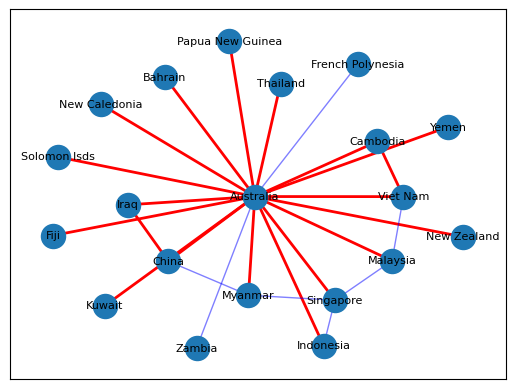

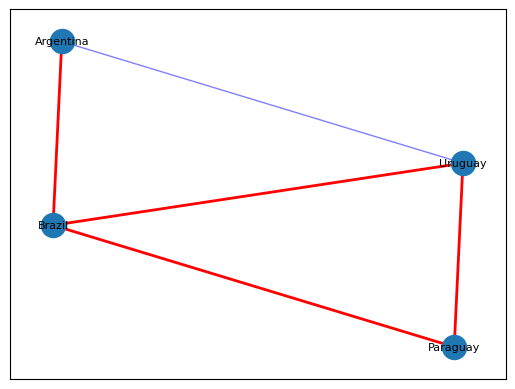

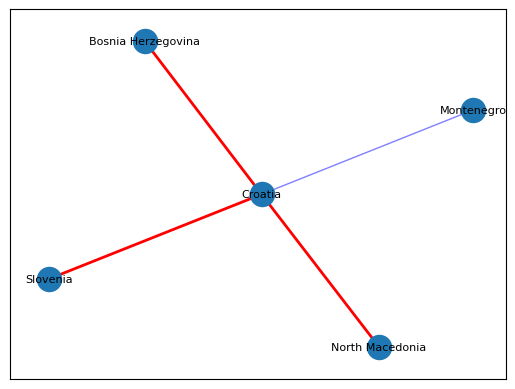

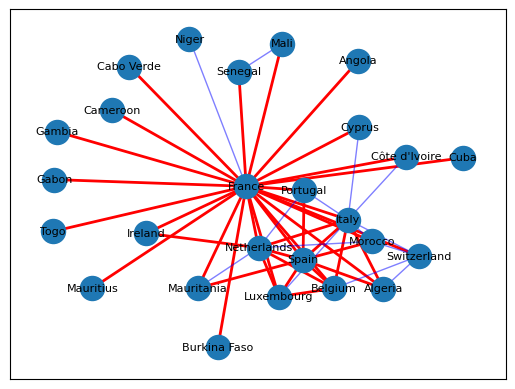

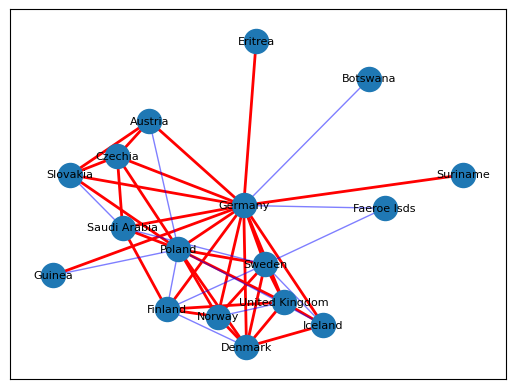

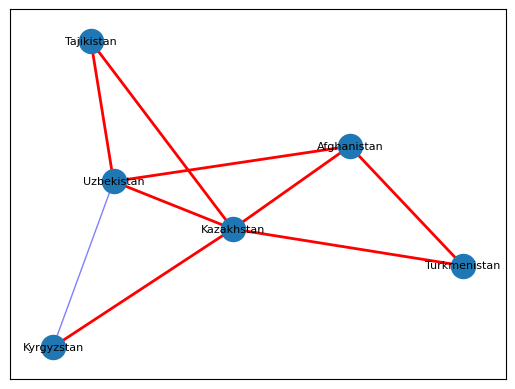

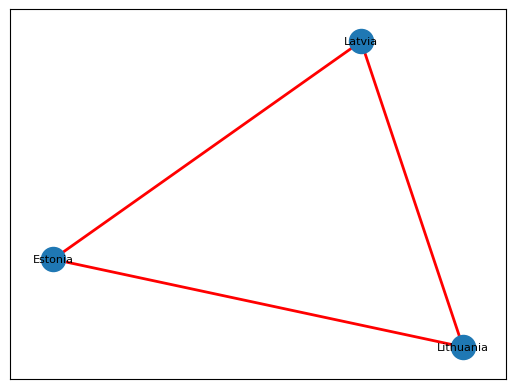

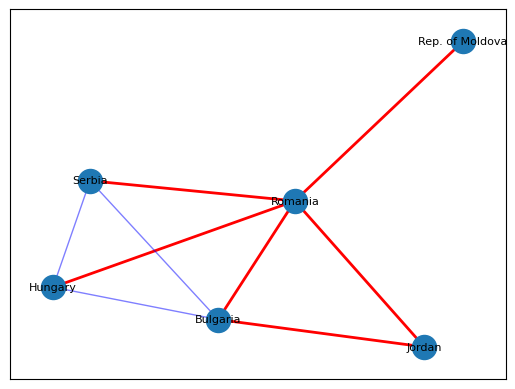

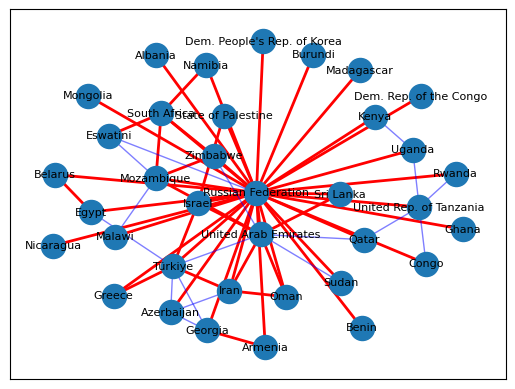

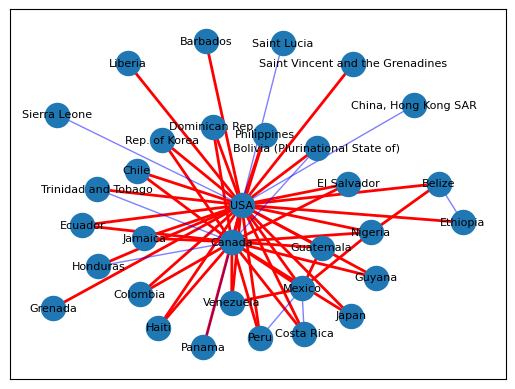

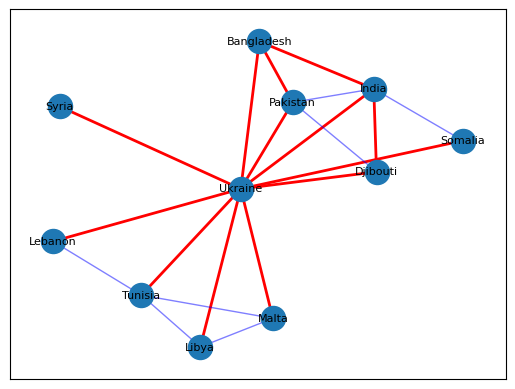

In [14]:
import matplotlib.pyplot as plt
import networkx as nx

ids, counts = np.unique(clustering, return_counts = True)

avg_weight = trade_map_sparse.mean()

for i,c in enumerate(ids):
    G = nx.Graph()

    
    for j in range(clustering.shape[0]):
        if clustering[j] == c:
            #print(c,le.inverse_transform([j])[0])
            for k in range(clustering.shape[0]):
                if clustering[k] == c:
                    if  trade_map_sparse[j,k] > 0.:
                        #print(c,le.inverse_transform([j])[0], le.inverse_transform([k])[0], trade_map_sparse[j,k])
                        G.add_edge(le.inverse_transform([[j]])[0][0], le.inverse_transform([[k]])[0][0], weight= trade_map_sparse[j,k])
                        
    elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > avg_weight]
    esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= avg_weight]

    if len(elarge + esmall) > 2 and len(elarge) > 0:
        layout = nx.spring_layout(G, seed=7,weight=None)
        #nx.draw(G, layout)
        nx.draw_networkx_nodes(G, layout, node_size=300)
    
        # edges
        nx.draw_networkx_edges(G, layout, edgelist=elarge, width=2,edge_color="r")
        nx.draw_networkx_edges(
            G, layout, edgelist=esmall, width=1, alpha=0.5, edge_color="b"
        )
        
        # node labels
        nx.draw_networkx_labels(G, layout, font_size=8, font_family="sans-serif")
        # edge weight labels
        #edge_labels = nx.get_edge_attributes(G, "weight")
        #nx.draw_networkx_edge_labels(G, layout, edge_labels,font_size=6)
        plt.show()    

    

In [15]:
trade_export

array([[2015, 2, -1, 11000.0],
       [2015, 2, 40, 11000.0],
       [2015, 9, -1, 4311203960.0],
       ...,
       [2017, 235, 234, 0.0],
       [2018, 235, 234, 0.0],
       [2021, 235, 234, 0.0]], dtype=object)

In [16]:
years = np.unique(trade_export[:,0])

In [ ]:
years

In [ ]:
from sklearn.preprocessing import LabelEncoder
# TODO: fill trade export
trade_clusters = []
#; un['num_states'] : nb of states, an integer (N)
#; un['production'] : tensor of size N, each element is a production value, a float number > 0
#; un['export'] : tensor of size N x N, each element is a value of export, a float number > 0
#; un['pred_export']

for i,c in enumerate(ids):
    
    for year in years:
        countries = {}
        export = []
        pred_export = []
        cle = LabelEncoder()
        for j in range(clustering.shape[0]):
            if clustering[j] == c:
                for k in range(clustering.shape[0]):
                    if clustering[k] == c:
                        ty = trade_export[trade_export[:,0] == year]
                        if len(ty) > 0:
                            tyj = ty[ty[:,1] == j]
                            if len(tyj) > 0:
                                tyjk = tyj[tyj[:,2] == k]
                        
                                if len(tyjk) > 0:
                                    if j not in countries:
                                        countries[j] = True
                                    if k not in countries:
                                        countries[k] = True
                                    export.append([j,k,tyjk[0,3]])
                                    #TODO fill gaps with ARIMA!!!
                                    old = tyjk[0,3]    
                                    ty = trade_export[trade_export[:,0] == year + 1]
                                    if len(ty) > 0:
                                        tyj = ty[ty[:,1] == j]
                                        tyjk = tyj[tyj[:,2] == k]
                                        if len(tyjk) > 0:
                                            pred_export.append([j,k,tyjk[0,3]])
                                        else:
                                             #TODO replace with ARIMA
                                             pred_export.append([j,k,old])
                            
        cle.fit(list(countries.keys())) 
        num_states = len(cle.classes_)
        export_matrix = np.zeros((num_states,num_states))
        pred_export_matrix = np.zeros((num_states,num_states))
        for j,k,v in export:
            export_matrix[cle.transform([j])[0],cle.transform([k])[0]] = v
        for j,k,v in pred_export:
            pred_export_matrix[cle.transform([j])[0],cle.transform([k])[0]] = v

        if num_states > 3 and len(export) > 0:
            pred_export_matrix = pred_export_matrix#.flatten()
            #pred_export_matrix = np.hstack([pred_export_matrix,np.zeros((num_labels * num_labels - pred_export_matrix.shape[0]))])   
            trade_clusters.append({'year': year,'state_list': list(countries.keys()), 'label_enc': cle,'num_states':num_states,'cluster_id': c,'export':export_matrix, 'pred_export': pred_export_matrix})    
        
                        

In [ ]:
len(trade_clusters)

# Load FAO

In [ ]:

fao = pd.read_csv("prod_data/FAOSTAT_data_en_1-28-2025.csv")[["Area", "Year", "Value"]].to_numpy()
fao = np.hstack([le.transform(fao[:,0].reshape(-1,1)).astype(int),fao[:,1:3]])

In [ ]:
for c in trade_clusters:
    prod = np.zeros((c['num_states'],))
    for country in c['state_list']:
        fc = fao[fao[:,0] == country]
        if len(fc) > 0:
            fcy = fc[fc[:,1] == c['year']]
            if len(fcy) > 0:
                prod[c['label_enc'].transform([country])[0]] = fcy[0,2]
    c['production'] = prod            
            

# Transformer regressor

In [ ]:
from layers.graph_transformer_edge_layer import GraphTransformerLayer
from layers.mlp_readout_layer import MLPReadout
import torch
from torch import nn

import hashlib

import dgl

class GraphTransformerNet(nn.Module):
    def __init__(self, net_params):
        super().__init__()
        num_states = net_params['num_states']
        num_trade_indicators = net_params['num_trade_indicators']
        hidden_dim = net_params['hidden_dim']
        num_heads = net_params['n_heads']
        out_dim = net_params['out_dim']
        in_feat_dropout = net_params['in_feat_dropout']
        dropout = net_params['dropout']
        n_layers = net_params['L']
        self.layer_norm = net_params['layer_norm']
        self.batch_norm = net_params['batch_norm']
        self.residual = net_params['residual']
        self.edge_feat = net_params['edge_feat']
        self.device = net_params['device']
        self.lap_pos_enc = net_params['lap_pos_enc']
        self.wl_pos_enc = net_params['wl_pos_enc']
        max_wl_role_index = net_params['max_cluster_size'] # this is maximum graph size in the dataset
        self.num_states = num_states
        if self.lap_pos_enc:
            pos_enc_dim = net_params['pos_enc_dim']
            self.embedding_lap_pos_enc = nn.Linear(pos_enc_dim, hidden_dim,dtype=torch.double)
        if self.wl_pos_enc:
            self.embedding_wl_pos_enc = nn.Embedding(max_wl_role_index, hidden_dim)
        
        self.embedding_h = nn.Linear(1, hidden_dim,dtype=torch.double)

        if self.edge_feat:
            #self.embedding_e = nn.Embedding(num_trade_indicators, hidden_dim)
            self.embedding_e = nn.Linear(1, hidden_dim,dtype=torch.double)
        else:
            self.embedding_e = nn.Linear(1, hidden_dim,dtype=torch.double)
        
        self.in_feat_dropout = nn.Dropout(in_feat_dropout)
        
        self.layers = nn.ModuleList([ GraphTransformerLayer(hidden_dim, hidden_dim, num_heads, dropout,
                                                    self.layer_norm, self.batch_norm, self.residual) for _ in range(n_layers-1) ]) 
        self.layers.append(GraphTransformerLayer(hidden_dim, hidden_dim, num_heads, dropout, self.layer_norm, self.batch_norm, self.residual))
        self.MLP_layer = MLPReadout(hidden_dim, 1)
        
    def forward(self, g, h, e, h_lap_pos_enc=None, h_wl_pos_enc=None):

        # input embedding
        h = self.embedding_h(h)
        h = self.in_feat_dropout(h)
        if self.lap_pos_enc:
            h_lap_pos_enc = self.embedding_lap_pos_enc(h_lap_pos_enc.double()) 
            h = h + h_lap_pos_enc
        if self.wl_pos_enc:
            h_wl_pos_enc = self.embedding_wl_pos_enc(h_wl_pos_enc) 
            h = h + h_wl_pos_enc
        if not self.edge_feat: # edge feature set to 1
            e = torch.ones(e.size(0),1).to(self.device)
        e = self.embedding_e(e)  

        #print("h: ", h.shape)
        #print("e: ", e.shape)
        
        # convnets
        for conv in self.layers:
            h, e = conv(g, h, e)
        g.ndata['h'] = h
        g.edata['h'] = e
        
        e = e.reshape((-1,e.shape[1]))
        ez = torch.zeros((self.num_states*self.num_states - e.shape[0], e.shape[1]))
        e = torch.vstack([e,ez])

        #print("pre-out dim:", e.shape)
        mlp = self.MLP_layer(e)
        return mlp.reshape(1,-1)
        
        
    def loss(self, scores, targets):
        loss = nn.MSELoss()(scores,targets)
        #loss = nn.L1Loss()(scores, targets)
        return loss

def train_epoch(model, optimizer, device, data_loader, epoch):
    model.train()
    epoch_loss = 0
    epoch_train_mae = 0
    nb_data = 0
    gpu_mem = 0
    for iter, (batch_graphs, batch_targets) in enumerate(data_loader):
        batch_graphs = batch_graphs.to(device)
        batch_x = batch_graphs.ndata['feat'].reshape(-1,1).to(device)  # num x feat
        batch_e = batch_graphs.edata['feat'].reshape(-1,1).to(device)

        batch_targets = batch_targets.edata['feat'].reshape(1,-1)
        ez = torch.zeros((1,model.num_states*model.num_states - batch_targets.shape[1]))
        batch_targets = torch.hstack([batch_targets,ez])
        batch_targets = batch_targets.to(device)
        
        optimizer.zero_grad()
        try:
            batch_lap_pos_enc = batch_graphs.ndata['lap_pos_enc'].to(device)
            sign_flip = torch.rand(batch_lap_pos_enc.size(1)).to(device)
            sign_flip[sign_flip>=0.5] = 1.0; sign_flip[sign_flip<0.5] = -1.0
            batch_lap_pos_enc = batch_lap_pos_enc * sign_flip.unsqueeze(0)
        except:
            batch_lap_pos_enc = None
            
        try:
            batch_wl_pos_enc = batch_graphs.ndata['wl_pos_enc'].to(device)
        except:
            batch_wl_pos_enc = None

        batch_scores = model.forward(batch_graphs, batch_x, batch_e, batch_lap_pos_enc, batch_wl_pos_enc)
        loss = model.loss(batch_scores, batch_targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
        nb_data += batch_targets.size(0)
    epoch_loss /= (iter + 1)
    
    return epoch_loss, optimizer

def evaluate_network(model, device, data_loader, epoch):
    model.eval()
    epoch_test_loss = 0
    epoch_test_mae = 0
    nb_data = 0
    with torch.no_grad():
        for iter, (batch_graphs, batch_targets) in enumerate(data_loader):
            batch_graphs = batch_graphs.to(device)
            batch_x = batch_graphs.ndata['feat'].reshape(-1,1).to(device)
            batch_e = batch_graphs.edata['feat'].reshape(-1,1).to(device)
            batch_targets = batch_targets.edata['feat'].reshape(1,-1)
            ez = torch.zeros((1,model.num_states*model.num_states - batch_targets.shape[1]))
            batch_targets = torch.hstack([batch_targets,ez])
            batch_targets = batch_targets.to(device)
            try:
                batch_lap_pos_enc = batch_graphs.ndata['lap_pos_enc'].to(device)
            except:
                batch_lap_pos_enc = None
            
            try:
                batch_wl_pos_enc = batch_graphs.ndata['wl_pos_enc'].to(device)
            except:
                batch_wl_pos_enc = None
                
            batch_scores = model.forward(batch_graphs, batch_x, batch_e, batch_lap_pos_enc, batch_wl_pos_enc)
            loss = model.loss(batch_scores, batch_targets)
            epoch_test_loss += loss.detach().item()
            nb_data += batch_targets.size(0)
        epoch_test_loss /= (iter + 1)
        
    return epoch_test_loss 



In [ ]:
import scipy.sparse as sp

def laplacian_positional_encoding(g, pos_enc_dim):
    """
        Graph positional encoding v/ Laplacian eigenvectors
    """

    # Laplacian
    A = g.adj_external(scipy_fmt='csr')
    N = sp.diags(dgl.backend.asnumpy(g.in_degrees()).clip(1) ** -0.5, dtype=float)
    L = sp.eye(g.number_of_nodes()) - N * A * N

    # Eigenvectors with numpy
    EigVal, EigVec = np.linalg.eig(L.toarray())
    idx = EigVal.argsort() # increasing order

    pos_enc = torch.from_numpy(EigVec[:,1:pos_enc_dim+1]).double() 
    if pos_enc.shape[1] < pos_enc_dim:
        df = pos_enc_dim - pos_enc.shape[1]
        dfz = torch.zeros((pos_enc.shape[0],df))
        pos_enc = torch.hstack([pos_enc,dfz])
        #print("Ext on ", df)
    g.ndata['lap_pos_enc'] = pos_enc
    
    return g

def wl_positional_encoding(g):
    """
        WL-based absolute positional embedding 
        adapted from 
        
        "Graph-Bert: Only Attention is Needed for Learning Graph Representations"
        Zhang, Jiawei and Zhang, Haopeng and Xia, Congying and Sun, Li, 2020
        https://github.com/jwzhanggy/Graph-Bert
    """
    max_iter = 2
    node_color_dict = {}
    node_neighbor_dict = {}

    edge_list = torch.nonzero(g.adj().to_dense() != 0, as_tuple=False).numpy()
    node_list = g.nodes().numpy()

    # setting init
    for node in node_list:
        node_color_dict[node] = 1
        node_neighbor_dict[node] = {}

    for pair in edge_list:
        u1, u2 = pair
        if u1 not in node_neighbor_dict:
            node_neighbor_dict[u1] = {}
        if u2 not in node_neighbor_dict:
            node_neighbor_dict[u2] = {}
        node_neighbor_dict[u1][u2] = 1
        node_neighbor_dict[u2][u1] = 1


    # WL recursion
    iteration_count = 1
    exit_flag = False
    while not exit_flag:
        new_color_dict = {}
        for node in node_list:
            neighbors = node_neighbor_dict[node]
            neighbor_color_list = [node_color_dict[neb] for neb in neighbors]
            color_string_list = [str(node_color_dict[node])] + sorted([str(color) for color in neighbor_color_list])
            color_string = "_".join(color_string_list)
            hash_object = hashlib.md5(color_string.encode())
            hashing = hash_object.hexdigest()
            new_color_dict[node] = hashing
        color_index_dict = {k: v+1 for v, k in enumerate(sorted(set(new_color_dict.values())))}
        for node in new_color_dict:
            new_color_dict[node] = color_index_dict[new_color_dict[node]]
        if node_color_dict == new_color_dict or iteration_count == max_iter:
            exit_flag = True
        else:
            node_color_dict = new_color_dict
        iteration_count += 1
        
    g.ndata['wl_pos_enc'] = torch.LongTensor(list(node_color_dict.values()))
    return g


class TradeDGL(torch.utils.data.Dataset):
    def __init__(self, data,device):
        self.data = data
        self.device = device
        self.num_graphs = len(data)
                
        """
        data is a list of TradeUnion dict objects with following attributes
        
          un = data[idx]
        ; un['num_states'] : nb of states, an integer (N)
        ; un['production'] : tensor of size N, each element is a production value, a float number > 0
        ; un['export'] : tensor of size N x N, each element is a value of export, a float number > 0
        ; un['pred_export'] : tensor of size N x N, each element is a value of export, a float number > 0
        """
        
        self.graph_lists = []
        self.graph_labels = []
        self.n_samples = len(self.data)
        self._prepare()

    # form a mini batch from a given list of samples = [(graph, label) pairs]
    def collate(self, samples):
        # The input samples is a list of pairs (graph, label).
        graphs, labels = map(list, zip(*samples))
        #print(labels,)
        labels = dgl.batch(labels) 
        batched_graph = dgl.batch(graphs)       
        #print(batched_graph)          
        return batched_graph, labels
    
    def _add_laplacian_positional_encodings(self, pos_enc_dim):
        
        # Graph positional encoding v/ Laplacian eigenvectors
        self.graph_lists = [laplacian_positional_encoding(g, pos_enc_dim) for g in self.graph_lists]

    def _add_wl_positional_encodings(self):
        
        # WL positional encoding from Graph-Bert, Zhang et al 2020.
        self.graph_lists = [wl_positional_encoding(g) for g in self.graph_lists]
    
    def _prepare(self):
       
        for un in self.data:
            node_features = torch.from_numpy(un['production']).to(device=self.device)
            
            adj = torch.from_numpy(un['export']).to(device=self.device)

            edge_list = (adj != 0).nonzero()  # converting adj matrix to edge_list
            
            edge_idxs_in_adj = edge_list.split(1, dim=1)
            edge_features = adj[edge_idxs_in_adj].reshape(-1)
            
            # Create the DGL Graph
            g = dgl.DGLGraph()
            g.my_id = (un['year'],un["cluster_id"])
            g.add_nodes(un['num_states'])
            g.ndata['feat'] = node_features
            
            for src, dst in edge_list:
                g.add_edges(src.item(), dst.item())
            g.edata['feat'] = edge_features
            self.graph_lists.append(g)
            
            # Create the target DGL Graph
            g = dgl.DGLGraph()
            g.my_id = (un['year'] + 1,un["cluster_id"])
            g.add_nodes(un['num_states'])
            g.ndata['feat'] = node_features
            adj = torch.from_numpy(un['pred_export']).to(device=self.device)
            edge_list = (adj != 0).nonzero()  # converting adj matrix to edge_list
            
            edge_idxs_in_adj = edge_list.split(1, dim=1)
            edge_features = adj[edge_idxs_in_adj].reshape(-1)
            
            for src, dst in edge_list:
                g.add_edges(src.item(), dst.item())
  
            g.edata['feat'] = edge_features            
            self.graph_labels.append(g)
        
    def __len__(self):
        """Return the number of graphs in the dataset."""
        return self.n_samples

    def __getitem__(self, idx):
        """
            Get the idx^th sample.
            Parameters
            ---------
            idx : int
                The sample index.
            Returns
            -------
            (dgl.DGLGraph, int)
                DGLGraph with node feature stored in `feat` field
                And its label.
        """
        return self.graph_lists[idx], self.graph_labels[idx]


In [ ]:
import time
from torch import optim
from torch.utils.data import DataLoader
from tqdm import tqdm

max_cluster_size = 0
for c in trade_clusters:
    if c['num_states'] > max_cluster_size:
        max_cluster_size = c['num_states']

lap_pos_enc = True
wl_pos_enc = True
device = "cpu"
batch_size = 8
epochs = 10

root_log_dir = ""
root_ckpt_dir = ""
write_file_name = ""
write_config_file = ""
min_lr = 0.00001

net_params = {}
net_params['num_states'] = num_labels
net_params['num_trade_indicators'] = 1
net_params['hidden_dim'] = 4
net_params['n_heads'] = 4
net_params['out_dim'] = 1
net_params['in_feat_dropout'] = True
net_params['dropout'] = True
net_params['L'] = 4
net_params['layer_norm'] = True
net_params['batch_norm'] = True
net_params['residual'] = True
net_params['edge_feat'] = True
net_params['device'] = device
net_params['lap_pos_enc'] = True
net_params['wl_pos_enc'] = True
net_params['max_cluster_size'] = max_cluster_size
net_params['pos_enc_dim'] = 4

dataset = TradeDGL(trade_clusters,device)

train_len = int(len(trade_clusters)*0.6)
val_len = int(len(trade_clusters)*0.2)
test_len = len(trade_clusters) - train_len - val_len

if lap_pos_enc:
    st = time.time()
    print("[!] Adding Laplacian positional encoding.")
    dataset._add_laplacian_positional_encodings(net_params['pos_enc_dim'])
    print('Time LapPE:',time.time()-st)
    
if wl_pos_enc:
    st = time.time()
    print("[!] Adding WL positional encoding.")
    dataset._add_wl_positional_encodings()
    print('Time WL PE:',time.time()-st)

trainset, valset, testset = torch.utils.data.random_split(dataset, [train_len, val_len, test_len])


model = GraphTransformerNet(net_params)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                 factor=0.1,
                                                 patience=10,
                                                 verbose=True)

epoch_train_losses, epoch_val_losses = [], []
    

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=dataset.collate)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, collate_fn=dataset.collate)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, collate_fn=dataset.collate)

try:
    with tqdm(range(epochs)) as t:
        for epoch in t:

            t.set_description('Epoch %d' % epoch)

            start = time.time()

            epoch_train_loss, optimizer = train_epoch(model, optimizer, device, train_loader, epoch)
                
            epoch_val_loss = evaluate_network(model, device, val_loader, epoch)
            
            epoch_train_losses.append(epoch_train_loss)
            epoch_val_losses.append(epoch_val_loss)

            # writer.add_scalar('train/_loss', epoch_train_loss, epoch)
            # writer.add_scalar('val/_loss', epoch_val_loss, epoch)
            # writer.add_scalar('learning_rate', optimizer.param_groups[0]['lr'], epoch)

            t.set_postfix(time=time.time()-start, lr=optimizer.param_groups[0]['lr'],
                          train_loss=epoch_train_loss, val_loss=epoch_val_loss)

            #per_epoch_time.append(time.time()-start)

            # Saving checkpoint
            ckpt_dir = os.path.join(root_ckpt_dir, "RUN_")
            if not os.path.exists(ckpt_dir):
                os.makedirs(ckpt_dir)
            torch.save(model.state_dict(), '{}.pkl'.format(ckpt_dir + "/epoch_" + str(epoch)))

            # files = glob.glob(ckpt_dir + '/*.pkl')
            # for file in files:
            #     epoch_nb = file.split('_')[-1]
            #     epoch_nb = int(epoch_nb.split('.')[0])
            #     if epoch_nb < epoch-1:
            #         os.remove(file)

            scheduler.step(epoch_val_loss)

            if optimizer.param_groups[0]['lr'] < min_lr:
                print("\n!! LR EQUAL TO MIN LR SET.")
                break
            
except KeyboardInterrupt:
    print('-' * 89)
    print('Exiting from training early because of KeyboardInterrupt')

print("Convergence Time (Epochs): {:.4f}".format(epoch))


#writer.close()


